In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo


In [2]:
import sys
import os

import numpy as np
import pandas as pd
import random
import tensorflow as tf

from tensorflow import keras
from keras import layers
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

from scripts.CustomCallbacks import CustomLogger
import scripts.utils as utils
import scripts.Slopes as Slopes

from tqdm import tqdm
import json

from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import operator
import statsmodels.api as sm

utils.reset_seeds(0)
pd.set_option('display.max_columns', 50)

In [3]:
def read_data(path):
    df = pd.read_csv(path)

    df.train_size = df.train_size.astype(int)
    df.random_seed = df.random_seed.astype(int)
    df.multiplier = df.multiplier.astype(float)
    for i in range(5):
        df[f"ext_bpoints_in_{chr(i+ord('a'))}"] = df[f"ext_bpoints_in_{chr(i+ord('a'))}"].astype(int)

    # lisame mugavusväärtused
    df["points_in_equal_regions"] = (df["train_size"] / 5).astype(int)
    df["points_in_diff_region"] = (
        df["points_in_equal_regions"] * df["multiplier"]).astype(int)
    df["total_points"] = 4*df["points_in_equal_regions"] + df["points_in_diff_region"]

    # tuunime välja väga kauged väärtused:
    cols_to_process = [*[f'abs_diff_in_{chr(a)}' for a in range(97, 97+5)],
                    *[f'rel_diff_in_{chr(a)}' for a in range(97, 97+5)],
                    *[f'raw_mean2_in_{chr(a)}' for a in range(97, 97+5)],
                    *[f'raw_mean3_in_{chr(a)}' for a in range(97, 97+5)],
                    *['mse_treeningul', 'mse_grid_testil', 'mse_treening_andmete_teine_myra'],
                    ]

    df[cols_to_process] = df.loc[:, cols_to_process][np.abs(stats.zscore(df.loc[:, cols_to_process])) < 3]
    df.dropna(inplace=True)

    df.sort_values(by=["train_size", "region", "multiplier", "random_seed"], inplace=True, ignore_index=True)
    df = df.groupby(['region', 'multiplier', 'train_size']).mean().reset_index()

    df["combo_name"] = df["train_size"].astype(str) + "_" + df["region"] + "_" + df["multiplier"].astype(str)
    return df

paths = ["andmed/all_four/const_order.csv", "andmed/all_four/const_reverse.csv", "andmed/all_four/sin_order.csv", "andmed/all_four/sin_reverse.csv"]
df = read_data(paths[0])


```new_transform ```võtab sisse dataFrame, enda piirkonna, naaber- ja kaugedpiirkonnad.
Jätab alles vaid osa andmetest:
<!-- - my_bpoints
- my_points
- my_points_m1
- my_points_log

- neighbour_bpoints
- neighbour_raw_mean2
- neighbour_points
- neighbour_points_m1
- neighbour_points_log

- distant_bpoints
- distant_raw_mean2
- distant_points
- distant_points_m1
- distant_points_log

- mse_treeningul -->

|   | my  |  naaber | kauge  |   
|---|---|---|---|
| raw_mean2  |   |   |   |   
| breakpoints  |   |   |   |   
| points  |   |   |   |   
| m1  |   |   |   |   
| log  |   |   |   |   

In [4]:
def new_transform(df, minu:str, naabrid:list[str], kaugemad:list[str]):
    ma_olen_reg = minu
    # naabrid = ['a','c']
    naabrid_upper = [n.upper() for n in naabrid]
    # kaugemad = ['d','e']
    kaugemad_upper = [k.upper() for k in kaugemad]


    # y_col = "rel_diff_in_"+ma_olen_reg

    df_new = pd.DataFrame()
    df_new["my_bpoints"] = df["bpoints_in_"+ma_olen_reg]
    if len(naabrid) == 2:
        df_new["neighbour_bpoints"] = (df["bpoints_in_"+naabrid[0]] + df["bpoints_in_"+naabrid[1]])/2
    else:
        df_new["neighbour_bpoints"] = df["bpoints_in_"+naabrid[0]]
    
    if len(kaugemad) == 2:
        df_new["distant_bpoints"] = (df["bpoints_in_"+kaugemad[0]] + df["bpoints_in_"+kaugemad[1]])/2
    else:
        df_new["distant_bpoints"] = df["bpoints_in_"+kaugemad[0]]


    df_new["my_rel_diff"] = df["rel_diff_in_"+ma_olen_reg]

    df_new["my_raw_mean2"] = df["raw_mean2_in_"+ma_olen_reg]
    if len(naabrid) == 2:
        df_new["neighbour_raw_mean2"] = (df["raw_mean2_in_"+naabrid[0]] + df["raw_mean2_in_"+naabrid[1]])/2
    else:
        df_new["neighbour_raw_mean2"] = df["raw_mean2_in_"+naabrid[0]]
    
    if len(kaugemad) == 2:
        df_new["distant_raw_mean2"] = (df["raw_mean2_in_"+kaugemad[0]] + df["raw_mean2_in_"+kaugemad[1]])/2
    else:
        df_new["distant_raw_mean2"] = df["raw_mean2_in_"+kaugemad[0]]

    # minus olevad punktid
    df_new["my_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == ma_olen_reg.upper())) + (df["train_size"]/5 * (df["region"] != ma_olen_reg.upper()))
    df_new["my_points"] = df_new["my_points"].astype(int)

    if len(naabrid) == 2:
        df_new["neighbour_points"] = (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[0])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[0]))
        df_new["neighbour_points"] += (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[1])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[1]))
        df_new["neighbour_points"] = (df_new["neighbour_points"]/2).astype(int)
    else:
        df_new["neighbour_points"] = (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[0])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[0]))
        df_new["neighbour_points"] = df_new["neighbour_points"].astype(int)	

    if len(kaugemad) == 2:
        df_new["distant_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[0])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[0]))
        df_new["distant_points"] += (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[1])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[1]))
        df_new["distant_points"] = (df_new["distant_points"]/2).astype(int)
    else:
        df_new["distant_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[0])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[0]))
        df_new["distant_points"] = df_new["distant_points"].astype(int)
    
    # et ei oleks ühtegi nulli enam
    df_new["my_points"] = (df_new["my_points"]+1).astype(float)
    df_new["neighbour_points"] = (df_new["neighbour_points"]+1).astype(float)
    df_new["distant_points"] = (df_new["distant_points"]+1).astype(float)


    df_new["my_points_m1"] = df_new["my_points"] ** (-1)
    # df_new["my_points_m2"] = df_new["my_points"] ** (-2)
    # df_new["my_points_m3"] = df_new["my_points"] ** (-3)
    # df_new["my_points_m4"] = df_new["my_points"] ** (-4)
    # df_new["my_points_m5"] = df_new["my_points"] ** (-5)
    # df_new["my_points_m6"] = df_new["my_points"] ** (-6)
    df_new["my_points_log"] = np.log(df_new["my_points"])


    df_new["neighbour_points_m1"] = df_new["neighbour_points"] ** (-1)
    # df_new["neighbour_points_m2"] = df_new["neighbour_points"] ** (-2)
    # df_new["neighbour_points_m3"] = df_new["neighbour_points"] ** (-3)
    # df_new["neighbour_points_m4"] = df_new["neighbour_points"] ** (-4)
    # df_new["neighbour_points_m5"] = df_new["neighbour_points"] ** (-5)
    # df_new["neighbour_points_m6"] = df_new["neighbour_points"] ** (-6)
    df_new["neighbour_points_log"] = np.log(df_new["neighbour_points"])


    df_new["distant_points_m1"] = df_new["distant_points"] ** (-1)
    # df_new["distant_points_m2"] = df_new["distant_points"] ** (-2)
    # df_new["distant_points_m3"] = df_new["distant_points"] ** (-3)
    # df_new["distant_points_m4"] = df_new["distant_points"] ** (-4)
    # df_new["distant_points_m5"] = df_new["distant_points"] ** (-5)
    # df_new["distant_points_m6"] = df_new["distant_points"] ** (-6)
    df_new["distant_points_log"] = np.log(df_new["distant_points"])

    df_new["mse_treeningul"] = df["mse_treeningul"]
    df_new.dropna(inplace=True)
    df_new.reset_index(inplace=True, drop=True)


    X = df_new.drop(columns=['my_rel_diff'])
    y = df_new['my_rel_diff']

    uuritavad_col = X.columns

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X,)
    X = pd.DataFrame(X, columns=uuritavad_col)

    return X, y

df_order = read_data(paths[0])
uus_x, uus_y = new_transform(df_order, 'b', ['a','c'], ['d'])

uus_x.head()

,my_bpoints,neighbour_bpoints,distant_bpoints,my_raw_mean2,neighbour_raw_mean2,distant_raw_mean2,my_points,neighbour_points,distant_points,my_points_m1,my_points_log,neighbour_points_m1,neighbour_points_log,distant_points_m1,distant_points_log,mse_treeningul
0,0.786540,0.661417,0.173611,0.099200,0.266899,0.196170,0.00125,0.000000,0.00125,0.332917,0.148896,1.000000,0.000000,0.332917,0.148896,0.434014
1,0.757432,0.000000,0.555556,0.340877,0.255393,0.378296,0.00250,0.001001,0.00250,0.199500,0.218129,0.665999,0.065233,0.199500,0.218129,0.416949
2,0.850110,0.193049,0.383142,0.488457,0.381060,0.680474,0.00375,0.002002,0.00375,0.142321,0.263731,0.498999,0.111517,0.142321,0.263731,0.614349
3,0.644384,0.288775,0.306848,0.640313,0.566303,0.742816,0.00500,0.004004,0.00500,0.110556,0.297792,0.331999,0.176751,0.110556,0.297792,0.567813
4,0.414602,0.447069,0.270062,0.782012,0.462185,0.757815,0.00625,0.005005,0.00625,0.090341,0.324989,0.284284,0.201551,0.090341,0.324989,0.602476


In [5]:
regioon = ['a', 'b', 'c', 'd', 'e']
naabrid = [['b'], ['a','c'], ['b','d'], ['c','e'], ['d']]
kaugemad = [['c'], ['d'], ['a','e'], ['b'], ['c']]

In [6]:
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    print(f'Dropping feature: {max_p_value}')
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value


def kogu_asi(df,r,n,k):
    
    X, y = new_transform(df, r,n,k)

    kasutusel_featured = {col: 1 for col in X.columns}


    insignificant_feature = True
    while insignificant_feature:
        
        # model = sm.OLS(y, X)
        model = sm.tsa.arima.ARIMA(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:  # if there's only one insignificant variable left
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                # print(f'Dropping {removed} with p-value {results.pvalues[removed]}')
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        print(v, sep=";", end=";")

    
    # print(results.rsquared, sep=";", end=";")
    # print(results.mse_model, sep=";", end=";")
    # print(results.aic, sep=";", end=";")
    # print(results.bic, sep=";", end=";")
    print(results.summary())
    return results, X


X, y = new_transform(df_order, 'b', ['a','c'], ['d'])
kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;")

# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0,1,2,3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")

    df_ide_list = []
    print("koik", sep=";", end=";")

    for r, n, k in regioonide_combod:

        #print(r, sep=";", end=";")
        if type(kombo) is int:
            kombo = (kombo,)

        mega_df = pd.concat([read_data(paths[p])
                    for p in kombo], ignore_index=True)
        df_ide_list.append(mega_df)
    suur_df = pd.concat(df_ide_list, ignore_index=True)
    res, X = kogu_asi(suur_df, r,n,k)

        # kogu_asi(X, y, r,n,k)
        #print()
    print()
    break

predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;my_points;neighbour_points;distant_points;my_points_m1;my_points_log;neighbour_points_m1;neighbour_points_log;distant_points_m1;distant_points_log;mse_treeningul;r2;mse;aic;bic;
Komboks oli: (0, 1, 2, 3)
koik;Dropping feature: distant_points
1;1;1;1;1;1;1;1;0;1;1;1;1;1;1;1;                               SARIMAX Results                                
Dep. Variable:            my_rel_diff   No. Observations:                 9480
Model:                          ARIMA   Log Likelihood                3621.278
Date:                Sun, 30 Apr 2023   AIC                          -7208.556
Time:                        11:16:04   BIC                          -7086.888
Sample:                             0   HQIC                         -7167.262
                               - 9480                                         
Covariance Type:                  opg                         

## Katse 2

In [7]:
def transform_no_scaling(df, minu:str, naabrid:list[str], kaugemad:list[str]):
    ma_olen_reg = minu
    # naabrid = ['a','c']
    naabrid_upper = [n.upper() for n in naabrid]
    # kaugemad = ['d','e']
    kaugemad_upper = [k.upper() for k in kaugemad]

    # y_col = "rel_diff_in_"+ma_olen_reg

    df_new = pd.DataFrame()
    df_new["my_bpoints"] = df["bpoints_in_"+ma_olen_reg]
    if len(naabrid) == 2:
        df_new["neighbour_bpoints"] = (df["bpoints_in_"+naabrid[0]] + df["bpoints_in_"+naabrid[1]])/2
    else:
        df_new["neighbour_bpoints"] = df["bpoints_in_"+naabrid[0]]
    
    if len(kaugemad) == 2:
        df_new["distant_bpoints"] = (df["bpoints_in_"+kaugemad[0]] + df["bpoints_in_"+kaugemad[1]])/2
    else:
        df_new["distant_bpoints"] = df["bpoints_in_"+kaugemad[0]]

    df_new["my_rel_diff"] = df["rel_diff_in_"+ma_olen_reg]

    df_new["my_raw_mean2"] = df["raw_mean2_in_"+ma_olen_reg]
    if len(naabrid) == 2:
        df_new["neighbour_raw_mean2"] = (df["raw_mean2_in_"+naabrid[0]] + df["raw_mean2_in_"+naabrid[1]])/2
    else:
        df_new["neighbour_raw_mean2"] = df["raw_mean2_in_"+naabrid[0]]
    
    if len(kaugemad) == 2:
        df_new["distant_raw_mean2"] = (df["raw_mean2_in_"+kaugemad[0]] + df["raw_mean2_in_"+kaugemad[1]])/2
    else:
        df_new["distant_raw_mean2"] = df["raw_mean2_in_"+kaugemad[0]]

    # minus olevad punktid
    df_new["my_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == ma_olen_reg.upper())) + (df["train_size"]/5 * (df["region"] != ma_olen_reg.upper()))
    df_new["my_points"] = df_new["my_points"].astype(int)

    if len(naabrid) == 2:
        df_new["neighbour_points"] = (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[0])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[0]))
        df_new["neighbour_points"] += (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[1])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[1]))
        df_new["neighbour_points"] = (df_new["neighbour_points"]/2).astype(int)
    else:
        df_new["neighbour_points"] = (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[0])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[0]))
        df_new["neighbour_points"] = df_new["neighbour_points"].astype(int)	

    if len(kaugemad) == 2:
        df_new["distant_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[0])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[0]))
        df_new["distant_points"] += (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[1])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[1]))
        df_new["distant_points"] = (df_new["distant_points"]/2).astype(int)
    else:
        df_new["distant_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[0])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[0]))
        df_new["distant_points"] = df_new["distant_points"].astype(int)
    
    # et ei oleks ühtegi nulli enam
    df_new["my_points"] = (df_new["my_points"]+1).astype(float)
    df_new["neighbour_points"] = (df_new["neighbour_points"]+1).astype(float)
    df_new["distant_points"] = (df_new["distant_points"]+1).astype(float)


    df_new["my_points_m1"] = df_new["my_points"] ** (-1)
    df_new["my_points_log"] = np.log(df_new["my_points"])
    df_new["my_points_logm1"] = (np.log(df_new["my_points"])+1.0) ** (-1)

    df_new["neighbour_points_m1"] = df_new["neighbour_points"] ** (-1)
    df_new["neighbour_points_log"] = np.log(df_new["neighbour_points"])
    df_new["neighbour_points_logm1"] = (np.log(df_new["neighbour_points"]) +1.0)** (-1)


    df_new["distant_points_m1"] = df_new["distant_points"] ** (-1)
    df_new["distant_points_log"] = np.log(df_new["distant_points"])
    df_new["distant_points_logm1"] = (np.log(df_new["distant_points"]) +1.0) ** (-1)


    df_new["mse_treeningul"] = df["mse_treeningul"]
    df_new.dropna(inplace=True)
    df_new.reset_index(inplace=True, drop=True)

    df_new.drop_duplicates(inplace=True, ignore_index=True)
    
    X = df_new.drop(columns=['my_rel_diff'])
    y = df_new['my_rel_diff']

    # uuritavad_col = X.columns

    # scaler = MinMaxScaler()
    # X = scaler.fit_transform(X,)
    # X = pd.DataFrame(X, columns=uuritavad_col)

    return X, y#, df.train_size, df.multiplier

In [8]:
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    # print(f'Dropping feature: {max_p_value}')
    df.drop(columns=max_p_value, inplace=True)
    return df, max_p_value


def treeni_ols(X, y):
    """Võtab sisse transformeeritud X ja y ning tagastab OLS mudeli.

    :param X: x andmed
    :param y: y
    :return: model, x, y
    """
    
    kasutusel_featured = {col: 1 for col in X.columns}

    insignificant_feature = True
    while insignificant_feature:
        
        model = sm.OLS(y, X)
        # model = sm.tsa.arima.ARIMA(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        print(v, sep=";", end=";")

    print(results.rsquared, sep=";", end=";")
    print(results.mse_model, sep=";", end=";")
    print(results.aic, sep=";", end=";")
    print(results.bic, sep=";", end=";")
    # print(results.summary())
    return results, X, y

def treeni_ols_constant(X, y):
    """Võtab sisse transformeeritud X ja y ning tagastab OLS mudeli.

    :param X: x andmed
    :param y: y
    :return: model, x, y
    """
    
    X = sm.add_constant(X)
    kasutusel_featured = {col: 1 for col in X.columns}
    # print(kasutusel_featured)

    insignificant_feature = True
    while insignificant_feature:
        model = sm.OLS(y, X)
        # model = sm.tsa.arima.ARIMA(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        print(v, sep=";", end=";")

    print(results.rsquared, sep=";", end=";")
    print(results.mse_model, sep=";", end=";")
    print(results.aic, sep=";", end=";")
    print(results.bic, sep=";", end=";")
    # print(results.summary())
    return results, X, y

### Katsetame decision tree regressori kõige olulisemaid feature

In [9]:
kombo = (0,1,2,3)

Xid, yid = [],[]
tsizes = []

for r, n, k in regioonide_combod:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)
    # X, y, train_size = transform_no_scaling(andmestikud_koos, r, n, k)
    Xid.append(X)
    yid.append(y)      
    # tsizes.append(train_size)
        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)
# tsizes = pd.concat(tsizes, ignore_index=True)

uuritavad_col = X.columns
scaler = MinMaxScaler()
suurX = scaler.fit_transform(suurX,)
suurX = pd.DataFrame(suurX, columns=uuritavad_col)


In [10]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
minix, testx, miniy, testy = train_test_split(suurX, suury, test_size=0.2)
dtr.fit(minix, miniy)
dtr.score(testx, testy)

l = sorted(list(zip(minix.columns, dtr.feature_importances_)), key=lambda x: x[1], reverse=True)
for f, co in l:
    print(f"{f:<25} {co}")


ValueError: Found input variables with inconsistent numbers of samples: [47400, 2375]

In [11]:
from sklearn.inspection import permutation_importance
model = Lasso(alpha=0.00001)
minix, X_val, miniy, y_val = train_test_split(suurX, suury, test_size=0.2)
model.fit(minix, miniy)

r = permutation_importance(model, X_val, y_val,
                           n_repeats=100,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{minix.columns[i]:<20}, {r.importances_mean[i]:.3f}, +/- {r.importances_std[i]:.3f}")

ValueError: Found input variables with inconsistent numbers of samples: [47400, 2375]

## Blokkhaaval teeme asju

### Ainult my_points jätame sisse

In [12]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0,1,2,3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a','c'], ['d'])
X = X.loc[:, ~X.columns.str.contains('neighbour_points')]
X = X.loc[:, ~X.columns.str.contains('distant_points')]
kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
print("regular;m1;log;logm1")


for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [],[]

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)      
            

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    suurX = suurX.loc[:, ~suurX.columns.str.contains('neighbour_points')]
    suurX = suurX.loc[:, ~suurX.columns.str.contains('distant_points')]
    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols(suurX, suury)

    if 'my_points' in result.params:
        print(result.params.my_points, end=";")
    else:
        print("0", end=";")
    
    if 'my_points_m1' in result.params:
        print(result.params.my_points_m1, end=";")
    else:
        print("0", end=";")
    if 'my_points_log' in result.params:
        print(result.params.my_points_log, end=";")
    else:
        print("0", end=";")
    if "my_points_logm1" in result.params:
        print(result.params.my_points_logm1, end=";")
    else:
        print("0", end=";")

    print()
    #print(result.summary())

predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;my_points;my_points_m1;my_points_log;my_points_logm1;mse_treeningul;r2;mse;aic;bic;regular;m1;log;logm1
Komboks oli: (0, 1, 2, 3)
koik;1;1;1;1;1;1;1;1;1;1;1;0.4719766289101591;23.966152638311588;-3722.5003176827067;-3645.599979806358;-0.17091170252149748;0.3660069061541727;0.30331042489470744;-0.9967139029311676;
Komboks oli: (0, 1)
koik;1;1;1;1;1;1;0;1;1;1;1;0.5018022424849631;14.617600133244654;-1923.9020830235859;-1860.9117112074553;0;1.3674235082441424;-0.16742854356973552;-2.174239476625729;
Komboks oli: (2, 3)
koik;1;1;1;1;1;1;1;0;1;1;1;0.5856952429004713;15.65322467128181;-2993.93675401563;-2930.9712888126237;-0.1364519917045291;0;0.5812255821392041;-0.4141743951579583;
Komboks oli: (0, 2)
koik;1;1;1;1;1;1;1;1;1;1;1;0.8014617899846425;11.1946826789257;-8207.211789855179;-8137.908707766799;-0.23418019313940466;0.5179194077332178;0.09891437114390014;-1.2559904300318947;
K

### Ainult neighbour_points jätame sisse

In [13]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0,1,2,3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a','c'], ['d'])
X = X.loc[:, ~X.columns.str.contains('my_points')]
X = X.loc[:, ~X.columns.str.contains('distant_points')]
kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
print("regular;m1;log;logm1")


for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [],[]

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)      
            

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    suurX = suurX.loc[:, ~suurX.columns.str.contains('my_points')]
    suurX = suurX.loc[:, ~suurX.columns.str.contains('distant_points')]
    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols(suurX, suury)
    if 'neighbour_points' in result.params:
        print(result.params.neighbour_points, end=";")
    else:
        print("0", end=";")
    
    if 'neighbour_points_m1' in result.params:
        print(result.params.neighbour_points_m1, end=";")
    else:
        print("0", end=";")
    if 'neighbour_points_log' in result.params:
        print(result.params.neighbour_points_log, end=";")
    else:
        print("0", end=";")
    if "neighbour_points_logm1" in result.params:
        print(result.params.neighbour_points_logm1, end=";")
    else:
        print("0", end=";")

    print()
    #print(result.summary())

predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;neighbour_points;neighbour_points_m1;neighbour_points_log;neighbour_points_logm1;mse_treeningul;r2;mse;aic;bic;regular;m1;log;logm1
Komboks oli: (0, 1, 2, 3)
koik;1;1;1;1;1;1;1;0;1;1;1;0.44189544406144043;24.682550607868258;-3279.5919451701757;-3209.682547100768;-0.15521499338042985;0;0.24420263000194967;-0.7096307460066156;
Komboks oli: (0, 1)
koik;1;1;1;1;1;1;0;1;1;1;1;0.48448145851225954;14.11304221645758;-1786.5138831015083;-1723.5235112853777;0;1.248493429632295;-0.24711482083954378;-2.1111284742989076;
Komboks oli: (2, 3)
koik;1;1;1;1;1;1;1;0;1;1;1;0.543615721804467;14.528612160321691;-2606.036065849771;-2543.070600646765;-0.24312117379036086;0;0.5761337926329504;-0.42302772531376015;
Komboks oli: (0, 2)
koik;1;1;1;1;1;1;1;1;0;1;1;0.7668038548899492;11.781645156031587;-7561.595936925301;-7498.593135026775;-0.12677606473719089;0.2815493811575743;0;-1.115107099911454;
Komb

### Ainult distant_points jätame sisse

In [14]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0,1,2,3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a','c'], ['d'])
X = X.loc[:, ~X.columns.str.contains('my_points')]
X = X.loc[:, ~X.columns.str.contains('neighbour_points')]
kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
print("regular;m1;log;logm1")

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [],[]

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)      
            

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    suurX = suurX.loc[:, ~suurX.columns.str.contains('my_points')]
    suurX = suurX.loc[:, ~suurX.columns.str.contains('neighbour_points')]
    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols(suurX, suury)
    if 'distant_points' in result.params:
        print(result.params.distant_points, end=";")
    else:
        print("0", end=";")
    
    if 'distant_points_m1' in result.params:
        print(result.params.distant_points_m1, end=";")
    else:
        print("0", end=";")
    if 'distant_points_log' in result.params:
        print(result.params.distant_points_log, end=";")
    else:
        print("0", end=";")

    if "distant_points_logm1" in result.params:
        print(result.params.distant_points_logm1, end=";")
    else:
        print("0", end=";")
    

    print()
    #print(result.summary())

predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;distant_points;distant_points_m1;distant_points_log;distant_points_logm1;mse_treeningul;r2;mse;aic;bic;regular;m1;log;logm1
Komboks oli: (0, 1, 2, 3)
koik;1;1;1;1;1;1;1;1;1;1;1;0.4255036624524994;21.606336199410293;-3045.144313696166;-2968.2439758198175;-0.21810700380267065;0.23654522630400993;0.24583948403044653;-0.8559577625850862;
Komboks oli: (0, 1)
koik;1;1;1;1;1;1;0;1;1;1;1;0.4682100791749594;13.639053667520159;-1661.5913583717138;-1598.6009865555832;0;1.415907041097574;-0.29444467807390484;-2.2035707601503045;
Komboks oli: (2, 3)
koik;1;1;1;1;1;1;1;0;1;1;1;0.5387016417061795;14.39727901264195;-2563.089520359071;-2500.1240551560645;-0.2763890818759437;0;0.5951830709670369;-0.3807300642373222;
Komboks oli: (0, 2)
koik;1;1;0;1;1;1;1;1;1;1;1;0.7581704190255146;11.64899574747231;-7415.273730152128;-7352.270928253602;-0.16455660612399736;0.4373841720387945;0.04863330308338085

### Ainult logm1 jätame sisse

In [15]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a', 'c'], ['d'])
X.drop(columns=['my_points', 'neighbour_points', 'distant_points', 'my_points_m1', 'my_points_log',
                'neighbour_points_m1', 'neighbour_points_log', 'distant_points_m1', 'distant_points_log', ], inplace=True)
kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
print("my_logm1;neighbour_logm1;distant_logm1")

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [], []

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat(
            [read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    suurX.drop(columns=['my_points', 'neighbour_points', 'distant_points', 'my_points_m1', 'my_points_log',
               'neighbour_points_m1', 'neighbour_points_log', 'distant_points_m1', 'distant_points_log', ], inplace=True)
    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols(suurX, suury)

    if 'my_points_logm1' in result.params:
        print(result.params.my_points_logm1, end=";")
    else:
        print("0", end=";")
    if 'neighbour_points_logm1' in result.params:
        print(result.params.neighbour_points_logm1, end=";")
    else:
        print("0", end=";")

    if "distant_points_logm1" in result.params:
        print(result.params.distant_points_logm1, end=";")
    else:
        print("0", end=";")

    print()
    # print(result.summary())


predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;my_points_logm1;neighbour_points_logm1;distant_points_logm1;mse_treeningul;r2;mse;aic;bic;my_logm1;neighbour_logm1;distant_logm1
Komboks oli: (0, 1, 2, 3)
koik;1;1;1;0;1;1;1;1;0;1;0.46100472452761254;32.187400313062156;-3563.353255031254;-3507.4257365757276;-0.7181551058763314;-0.281865015578134;0;
Komboks oli: (0, 1)
koik;1;1;1;1;1;1;1;1;1;1;0.48600356075187967;14.157381360480738;-1798.4007532803626;-1735.410381464232;-0.6982853867013922;-0.34882122760022327;0.14051113005025817;
Komboks oli: (2, 3)
koik;1;1;1;1;1;1;1;1;1;1;0.5587375653125718;14.932756835808755;-2741.15454576534;-2678.189080562334;-0.7949583512062731;-0.23926609112158687;-0.20461790105654332;
Komboks oli: (0, 2)
koik;1;1;1;1;1;1;1;1;1;1;0.8048347295569493;12.365974861004723;-8278.179500912642;-8215.176699014115;-0.5680629462675039;-0.19507751227393444;-0.1471810312188738;
Komboks oli: (1, 3)
koik;1;1;1;1;1;1;1

### Koik pointid ja soberid

In [16]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a', 'c'], ['d'])
X.drop(columns=['my_points', 'neighbour_points', 'distant_points', 'my_points_m1', 'my_points_log',
                'neighbour_points_m1', 'neighbour_points_log', 'distant_points_m1', 'distant_points_log', ], inplace=True)
kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
print("my_logm1;neighbour_logm1;distant_logm1")

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [], []

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat(
            [read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    suurX.drop(columns=['my_points', 'neighbour_points', 'distant_points', 'my_points_m1', 'my_points_log',
               'neighbour_points_m1', 'neighbour_points_log', 'distant_points_m1', 'distant_points_log', ], inplace=True)
    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols(suurX, suury)

    if 'my_points_logm1' in result.params:
        print(result.params.my_points_logm1, end=";")
    else:
        print("0", end=";")
    if 'neighbour_points_logm1' in result.params:
        print(result.params.neighbour_points_logm1, end=";")
    else:
        print("0", end=";")

    if "distant_points_logm1" in result.params:
        print(result.params.distant_points_logm1, end=";")
    else:
        print("0", end=";")

    print()
    # print(result.summary())


predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;my_points_logm1;neighbour_points_logm1;distant_points_logm1;mse_treeningul;r2;mse;aic;bic;my_logm1;neighbour_logm1;distant_logm1
Komboks oli: (0, 1, 2, 3)
koik;1;1;1;0;1;1;1;1;0;1;0.46100472452761254;32.187400313062156;-3563.353255031254;-3507.4257365757276;-0.7181551058763314;-0.281865015578134;0;
Komboks oli: (0, 1)
koik;1;1;1;1;1;1;1;1;1;1;0.48600356075187967;14.157381360480738;-1798.4007532803626;-1735.410381464232;-0.6982853867013922;-0.34882122760022327;0.14051113005025817;
Komboks oli: (2, 3)
koik;1;1;1;1;1;1;1;1;1;1;0.5587375653125718;14.932756835808755;-2741.15454576534;-2678.189080562334;-0.7949583512062731;-0.23926609112158687;-0.20461790105654332;
Komboks oli: (0, 2)
koik;1;1;1;1;1;1;1;1;1;1;0.8048347295569493;12.365974861004723;-8278.179500912642;-8215.176699014115;-0.5680629462675039;-0.19507751227393444;-0.1471810312188738;
Komboks oli: (1, 3)
koik;1;1;1;1;1;1;1

## staatiline transform logm1 (my, naaber, distant)

### kaalude leidmine logm1 jaoks

In [17]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a', 'c'], ['d'])
X = X.loc[:, X.columns.str.contains('logm1')]

kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
print("my_logm1;neighbour_logm1;distant_logm1")

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [], []

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat(
            [read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    suurX = suurX.loc[:, suurX.columns.str.contains('logm1')]
    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols(suurX, suury)

    if 'my_points_logm1' in result.params:
        print(result.params.my_points_logm1, end=";")
    else:
        print("0", end=";")
    if 'neighbour_points_logm1' in result.params:
        print(result.params.neighbour_points_logm1, end=";")
    else:
        print("0", end=";")

    if "distant_points_logm1" in result.params:
        print(result.params.distant_points_logm1, end=";")
    else:
        print("0", end=";")

    print()
    # print(result.summary())

predict_region;my_points_logm1;neighbour_points_logm1;distant_points_logm1;r2;mse;aic;bic;my_logm1;neighbour_logm1;distant_logm1
Komboks oli: (0, 1, 2, 3)
koik;1;1;0;0.23157253370588704;64.6736785748929;-727.5991177129126;-713.617238099031;-0.5534349575998917;-0.1064246737444824;0;
Komboks oli: (0, 1)
koik;1;1;1;0.1601248395344591;15.54822914649707;161.56768281086806;180.46479435570726;-0.5069606255592207;-0.23045744961998238;0.18556245530272694;
Komboks oli: (2, 3)
koik;1;0;0;0.3234429446673449;86.44299475861163;-1045.3727973869327;-1039.076250866632;-0.7588494465985919;0;0;
Komboks oli: (0, 2)
koik;1;1;1;0.535067303962824;27.40367509319675;-4798.294692759691;-4779.393852190134;-0.4308952542401919;-0.19754387095039433;-0.12594006432845978;
Komboks oli: (1, 3)
koik;1;0;1;0.1253629084325235;25.380644521651078;1655.2955172823613;1667.8861150013663;-0.7674711251965046;0;0.2094020560417894;
Komboks oli: 0
koik;1;1;1;0.5287701981045776;10.123658686511936;-2972.886644611617;-2956.05408624043

### staatiliseks tegemine logm1

In [18]:
kombo = (0,1,2,3)
# kombo = (0)

Xid, yid = [],[]
tsizes, multipliers = [], []
for r, n, k in regioonide_combod[2:3]:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)
    X, y  = transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)


# logm1 pointide transform
coef2 = (-0.553434958 * (suurX.my_points_logm1 - np.min(suurX.my_points_logm1))) / (suurX.my_points_logm1 * (np.max(suurX.my_points_logm1)-np.min(suurX.my_points_logm1)))
my_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_logm1
my_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

coef2 = (-0.106424674 * (suurX.neighbour_points_logm1 - np.min(suurX.neighbour_points_logm1))) / (suurX.neighbour_points_logm1 * (np.max(suurX.neighbour_points_logm1)-np.min(suurX.neighbour_points_logm1)))
neighbour_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_points_logm1
neighbour_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

coef2 = (0.0 * (suurX.distant_points_logm1 - np.min(suurX.distant_points_logm1))) / (suurX.distant_points_logm1 * (np.max(suurX.distant_points_logm1)-np.min(suurX.distant_points_logm1)))
distant_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.distant_points_logm1
distant_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

suurX["logm1_combo"] = my_points_logm1_kordajaga_ja_scaleeritud+neighbour_points_logm1_kordajaga_ja_scaleeritud+distant_points_logm1_kordajaga_ja_scaleeritud

suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1", "neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log", 'my_points_logm1',
       'neighbour_points_logm1', 'distant_points_logm1',], axis=1, inplace=True)

In [19]:
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
scaler.fit(suurX,)
scaleeritudX = scaler.transform(suurX)
scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)

In [20]:
result, newX, newy = treeni_ols(scaleeritudX, suury)

1;1;1;1;0;1;1;1;0.6017222593029221;7.107873418697254;-1670.9476675470987;-1633.2771542855517;

In [21]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.602
Model:                            OLS   Adj. R-squared (uncentered):              0.600
Method:                 Least Squares   F-statistic:                              345.1
Date:                Sun, 30 Apr 2023   Prob (F-statistic):                   3.44e-314
Time:                        11:20:20   Log-Likelihood:                          842.47
No. Observations:                1606   AIC:                                     -1671.
Df Residuals:                    1599   BIC:                                     -1633.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
my_bpoints           -0.2158      0.038     -5.745      0.000      -0.289      -0.142
neighbour_bpoints    -0.3654      0.032    -11.280      0.000      -0.429      -0.302
distant_bpoints      -0.4961      0.022    -22.265      0.000      -0.540      -0.452
my_raw_mean2          0.9020      0.026     35.354      0.000       0.852       0.952
distant_raw_mean2    -0.6086      0.063     -9.683      0.000      -0.732      -0.485
mse_treeningul       -0.1503      0.037     -4.020      0.000      -0.224      -0.077
logm1_combo           0.1460      0.029      5.102      0.000       0.090       0.202
==============================================================================
Omnibus:                       78.779   Durbin-Watson:                   0.465
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.750
Skew:                          -0.522   Prob(JB):                     7.24e-21
Kurtosis:                       3.543   Cond. No.                         24.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## staatiline transform bpointidele

### bpointide kaalude leidmine

In [22]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a', 'c'], ['d'])
X = X.loc[:, X.columns.str.contains('bpoints')]

kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
print("my_bp;neighbour_bp;distant_bp")

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [], []

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat(
            [read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    suurX = suurX.loc[:, suurX.columns.str.contains('bpoints')]
    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols(suurX, suury)

    if 'my_bpoints' in result.params:
        print(result.params.my_bpoints, end=";")
    else:
        print("0", end=";")
    if 'neighbour_bpoints' in result.params:
        print(result.params.neighbour_bpoints, end=";")
    else:
        print("0", end=";")

    if "distant_bpoints" in result.params:
        print(result.params.distant_bpoints, end=";")
    else:
        print("0", end=";")

    print()
    # print(result.summary())

predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;r2;mse;aic;bic;my_bp;neighbour_bp;distant_bp
Komboks oli: (0, 1, 2, 3)
koik;1;1;1;0.20462664129677877;38.098811965601556;-448.8414501628886;-427.86863074206616;-0.38548694564774916;-0.041056802231402886;0.04485967893818055;
Komboks oli: (0, 1)
koik;1;0;1;0.14506254368474292;21.12850519952039;231.02339769404534;243.6214720572715;-0.3220039642523159;0;0.02841159238151987;
Komboks oli: (2, 3)
koik;1;1;1;0.3009288064703882;26.80863056820228;-910.1022211927057;-891.2125816318038;-0.5300998762540692;-0.07003943446931553;0.0984437036049993;
Komboks oli: (0, 2)
koik;1;1;0;0.5128751328035219;39.400641934115505;-4612.617654368722;-4600.017093989016;-0.3422655300228835;-0.07631100906482219;0;
Komboks oli: (1, 3)
koik;1;0;1;0.09743151542385431;19.72572820061552;1781.1947856366723;1793.7853833556774;-0.4632489413318985;0;0.1273199517058832;
Komboks oli: 0
koik;1;1;0;0.5167787669434883;14.84111208912442;-2924.1266482003393;-2912.90494261954

### bpoint kaalude staatiliseks tegemine

In [23]:
kombo = (0,1,2,3)
# kombo = (0)

Xid, yid = [],[]
tsizes, multipliers = [], []
for r, n, k in regioonide_combod[2:3]:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)
    X, y  = transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

bp = True
logm1 = True
if bp:
    # logm1 pointide transform
    coef2 = (-0.385486946 * (suurX.my_bpoints - np.min(suurX.my_bpoints))) / (suurX.my_bpoints * (np.max(suurX.my_bpoints)-np.min(suurX.my_bpoints)))
    my_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.my_bpoints
    my_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.041056802 * (suurX.neighbour_bpoints - np.min(suurX.neighbour_bpoints))) / (suurX.neighbour_bpoints * (np.max(suurX.neighbour_bpoints)-np.min(suurX.neighbour_bpoints)))
    neighbour_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_bpoints
    neighbour_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.044859679 * (suurX.distant_bpoints - np.min(suurX.distant_bpoints))) / (suurX.distant_bpoints * (np.max(suurX.distant_bpoints)-np.min(suurX.distant_bpoints)))
    distant_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.distant_bpoints
    distant_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["bpoints_combo"] = my_bpoints_kordajaga_ja_scaleeritud+neighbour_bpoints_kordajaga_ja_scaleeritud+distant_bpoints_kordajaga_ja_scaleeritud

    suurX.drop(["my_bpoints", "neighbour_bpoints", "distant_bpoints"], axis=1, inplace=True)

if logm1:
    coef2 = (-0.553434958 * (suurX.my_points_logm1 - np.min(suurX.my_points_logm1))) / (suurX.my_points_logm1 * (np.max(suurX.my_points_logm1)-np.min(suurX.my_points_logm1)))
    my_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_logm1
    my_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.106424674 * (suurX.neighbour_points_logm1 - np.min(suurX.neighbour_points_logm1))) / (suurX.neighbour_points_logm1 * (np.max(suurX.neighbour_points_logm1)-np.min(suurX.neighbour_points_logm1)))
    neighbour_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_points_logm1
    neighbour_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.0 * (suurX.distant_points_logm1 - np.min(suurX.distant_points_logm1))) / (suurX.distant_points_logm1 * (np.max(suurX.distant_points_logm1)-np.min(suurX.distant_points_logm1)))
    distant_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.distant_points_logm1
    distant_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["logm1_combo"] = my_points_logm1_kordajaga_ja_scaleeritud+neighbour_points_logm1_kordajaga_ja_scaleeritud+distant_points_logm1_kordajaga_ja_scaleeritud

    suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1", "neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log", 'my_points_logm1',
        'neighbour_points_logm1', 'distant_points_logm1',], axis=1, inplace=True)


In [24]:
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
scaler.fit(suurX,)
scaleeritudX = scaler.transform(suurX)
scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)

In [25]:
result, newX, newy = treeni_ols(scaleeritudX, suury)

1;1;1;1;1;1;0.6219275426837687;8.570974195201911;-1756.5620333160314;-1724.273021948991;

In [26]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.622
Model:                            OLS   Adj. R-squared (uncentered):              0.621
Method:                 Least Squares   F-statistic:                              438.7
Date:                Sun, 30 Apr 2023   Prob (F-statistic):                        0.00
Time:                        11:20:56   Log-Likelihood:                          884.28
No. Observations:                1606   AIC:                                     -1757.
Df Residuals:                    1600   BIC:                                     -1724.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
my_raw_mean2            0.6828      0.079      8.680      0.000       0.529       0.837
neighbour_raw_mean2     0.5367      0.105      5.131      0.000       0.332       0.742
distant_raw_mean2      -0.8819      0.077    -11.526      0.000      -1.032      -0.732
mse_treeningul         -0.1668      0.036     -4.610      0.000      -0.238      -0.096
bpoints_combo          -0.4256      0.016    -26.008      0.000      -0.458      -0.394
logm1_combo            -0.1165      0.018     -6.417      0.000      -0.152      -0.081
==============================================================================
Omnibus:                      230.368   Durbin-Watson:                   0.415
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              403.965
Skew:                          -0.918   Prob(JB):                     1.91e-88
Kurtosis:                       4.632   Cond. No.                         51.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## staatiline transform raw_mean2 (my, naaber, distant)

### raw_mean2 kaalude leidmine

In [27]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a', 'c'], ['d'])
X = X.loc[:, X.columns.str.contains('raw_mean2')]

kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
print("my_raw;neighbour_raw;distant_raw")

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [], []

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat(
            [read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    suurX = suurX.loc[:, suurX.columns.str.contains('raw_mean2')]
    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols(suurX, suury)

    if 'my_raw_mean2' in result.params:
        print(result.params.my_raw_mean2, end=";")
    else:
        print("0", end=";")
    if 'neighbour_raw_mean2' in result.params:
        print(result.params.neighbour_raw_mean2, end=";")
    else:
        print("0", end=";")

    if "distant_raw_mean2" in result.params:
        print(result.params.distant_raw_mean2, end=";")
    else:
        print("0", end=";")

    print()
    # print(result.summary())

predict_region;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;r2;mse;aic;bic;my_raw;neighbour_raw;distant_raw
Komboks oli: (0, 1, 2, 3)
koik;1;1;1;0.06507403884965068;12.115937368973087;849.2538386469259;870.2266580677483;0.22028697295156965;-0.08796275034931525;-0.3056530457418403;
Komboks oli: (0, 1)
koik;1;0;0;0.009934715825700047;2.8940026783928374;818.9285243190716;825.2275615006846;-0.052709373127660136;0;0;
Komboks oli: (2, 3)
koik;1;0;1;0.16180034999872428;21.621289067328576;-184.27226252733908;-171.67916948673786;0.2234009231466621;0;-0.45007874153021843;
Komboks oli: (0, 2)
koik;1;1;1;0.37983830439664557;19.453562952819947;-3638.7421510975746;-3619.8413105280165;0.4345832863719394;-0.14425108054447022;-0.5302631204702095;
Komboks oli: (1, 3)
koik;0;1;1;0.02201255739867103;4.456604440130917;2102.605085180582;2115.195682899587;0;-0.23228144932772976;0.177880687861843;
Komboks oli: 0
koik;1;1;1;0.3714848369073913;7.112325372242694;-2391.097806206004;-2374.265247834818;0.6825

### raw_mean2 kaalude staatiliseks tegemine

In [28]:
kombo = (0,1,2,3)
# kombo = (0)

Xid, yid = [],[]
tsizes, multipliers = [], []
for r, n, k in regioonide_combod[2:3]:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)
    X, y  = transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

bp = True
logm1 = True
raw_mean2 = False
if bp:
    # logm1 pointide transform
    coef2 = (-0.385486946 * (suurX.my_bpoints - np.min(suurX.my_bpoints))) / (suurX.my_bpoints * (np.max(suurX.my_bpoints)-np.min(suurX.my_bpoints)))
    my_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.my_bpoints
    my_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.041056802 * (suurX.neighbour_bpoints - np.min(suurX.neighbour_bpoints))) / (suurX.neighbour_bpoints * (np.max(suurX.neighbour_bpoints)-np.min(suurX.neighbour_bpoints)))
    neighbour_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_bpoints
    neighbour_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.044859679 * (suurX.distant_bpoints - np.min(suurX.distant_bpoints))) / (suurX.distant_bpoints * (np.max(suurX.distant_bpoints)-np.min(suurX.distant_bpoints)))
    distant_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.distant_bpoints
    distant_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["bpoints_combo"] = my_bpoints_kordajaga_ja_scaleeritud+neighbour_bpoints_kordajaga_ja_scaleeritud+distant_bpoints_kordajaga_ja_scaleeritud

    suurX.drop(["my_bpoints", "neighbour_bpoints", "distant_bpoints"], axis=1, inplace=True)

if logm1:
    coef2 = (-0.553434958 * (suurX.my_points_logm1 - np.min(suurX.my_points_logm1))) / (suurX.my_points_logm1 * (np.max(suurX.my_points_logm1)-np.min(suurX.my_points_logm1)))
    my_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_logm1
    my_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.106424674 * (suurX.neighbour_points_logm1 - np.min(suurX.neighbour_points_logm1))) / (suurX.neighbour_points_logm1 * (np.max(suurX.neighbour_points_logm1)-np.min(suurX.neighbour_points_logm1)))
    neighbour_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_points_logm1
    neighbour_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.0 * (suurX.distant_points_logm1 - np.min(suurX.distant_points_logm1))) / (suurX.distant_points_logm1 * (np.max(suurX.distant_points_logm1)-np.min(suurX.distant_points_logm1)))
    distant_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.distant_points_logm1
    distant_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["logm1_combo"] = my_points_logm1_kordajaga_ja_scaleeritud+neighbour_points_logm1_kordajaga_ja_scaleeritud+distant_points_logm1_kordajaga_ja_scaleeritud

    suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1", "neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log", 'my_points_logm1',
        'neighbour_points_logm1', 'distant_points_logm1',], axis=1, inplace=True)

if raw_mean2:
    coef2 = (0.220286973 * (suurX.my_raw_mean2 - np.min(suurX.my_raw_mean2))) / (suurX.my_raw_mean2 * (np.max(suurX.my_raw_mean2)-np.min(suurX.my_raw_mean2)))
    my_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.my_raw_mean2
    my_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.08796275 * (suurX.neighbour_raw_mean2 - np.min(suurX.neighbour_raw_mean2))) / (suurX.neighbour_raw_mean2 * (np.max(suurX.neighbour_raw_mean2)-np.min(suurX.neighbour_raw_mean2)))
    neighbour_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_raw_mean2
    neighbour_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.305653046 * (suurX.distant_raw_mean2 - np.min(suurX.distant_raw_mean2))) / (suurX.distant_raw_mean2 * (np.max(suurX.distant_raw_mean2)-np.min(suurX.distant_raw_mean2)))
    distant_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.distant_raw_mean2
    distant_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["raw_mean2_combo"] = my_raw_mean2_kordajaga_ja_scaleeritud+neighbour_raw_mean2_kordajaga_ja_scaleeritud+distant_raw_mean2_kordajaga_ja_scaleeritud
    suurX.drop(['my_raw_mean2', 'neighbour_raw_mean2', 'distant_raw_mean2'], axis=1, inplace=True)

In [29]:
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
scaler.fit(suurX,)
scaleeritudX = scaler.transform(suurX)
scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)

In [30]:
result, newX, newy = treeni_ols(scaleeritudX, suury)

1;1;1;1;1;1;0.6219275426837687;8.570974195201911;-1756.5620333160314;-1724.273021948991;

In [31]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.622
Model:                            OLS   Adj. R-squared (uncentered):              0.621
Method:                 Least Squares   F-statistic:                              438.7
Date:                Sun, 30 Apr 2023   Prob (F-statistic):                        0.00
Time:                        11:21:33   Log-Likelihood:                          884.28
No. Observations:                1606   AIC:                                     -1757.
Df Residuals:                    1600   BIC:                                     -1724.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
my_raw_mean2            0.6828      0.079      8.680      0.000       0.529       0.837
neighbour_raw_mean2     0.5367      0.105      5.131      0.000       0.332       0.742
distant_raw_mean2      -0.8819      0.077    -11.526      0.000      -1.032      -0.732
mse_treeningul         -0.1668      0.036     -4.610      0.000      -0.238      -0.096
bpoints_combo          -0.4256      0.016    -26.008      0.000      -0.458      -0.394
logm1_combo            -0.1165      0.018     -6.417      0.000      -0.152      -0.081
==============================================================================
Omnibus:                      230.368   Durbin-Watson:                   0.415
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              403.965
Skew:                          -0.918   Prob(JB):                     1.91e-88
Kurtosis:                       4.632   Cond. No.                         51.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## OLS Regression Results
- pmst raw_mean2 on hea eraldi sisse jätta
- ülejäänudele kombo sobib

In [32]:
kombo = (0, 1, 2, 3)
# kombo = (0)

Xid, yid = [], []
tsizes, multipliers = [], []
for r, n, k in regioonide_combod[2:3]:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p])
                                 for p in kombo], ignore_index=True)
    X, y = transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)


suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

bp = True
logm1 = True
raw_mean2 = False
if bp:
    # logm1 pointide transform
    coef2 = (-0.385486946 * (suurX.my_bpoints - np.min(suurX.my_bpoints))) / \
        (suurX.my_bpoints * (np.max(suurX.my_bpoints)-np.min(suurX.my_bpoints)))
    my_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.my_bpoints
    my_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.041056802 * (suurX.neighbour_bpoints - np.min(suurX.neighbour_bpoints))) / \
        (suurX.neighbour_bpoints *
         (np.max(suurX.neighbour_bpoints)-np.min(suurX.neighbour_bpoints)))
    neighbour_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_bpoints
    neighbour_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.044859679 * (suurX.distant_bpoints - np.min(suurX.distant_bpoints))) / \
        (suurX.distant_bpoints *
         (np.max(suurX.distant_bpoints)-np.min(suurX.distant_bpoints)))
    distant_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.distant_bpoints
    distant_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["bpoints_combo"] = my_bpoints_kordajaga_ja_scaleeritud + \
        neighbour_bpoints_kordajaga_ja_scaleeritud + \
        distant_bpoints_kordajaga_ja_scaleeritud

    suurX.drop(["my_bpoints", "neighbour_bpoints",
               "distant_bpoints"], axis=1, inplace=True)

if logm1:
    coef2 = (-0.553434958 * (suurX.my_points_logm1 - np.min(suurX.my_points_logm1))) / \
        (suurX.my_points_logm1 *
         (np.max(suurX.my_points_logm1)-np.min(suurX.my_points_logm1)))
    my_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_logm1
    my_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.106424674 * (suurX.neighbour_points_logm1 - np.min(suurX.neighbour_points_logm1))) / \
        (suurX.neighbour_points_logm1 * (np.max(suurX.neighbour_points_logm1) -
         np.min(suurX.neighbour_points_logm1)))
    neighbour_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_points_logm1
    neighbour_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.0 * (suurX.distant_points_logm1 - np.min(suurX.distant_points_logm1))) / \
        (suurX.distant_points_logm1 *
         (np.max(suurX.distant_points_logm1)-np.min(suurX.distant_points_logm1)))
    distant_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.distant_points_logm1
    distant_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["logm1_combo"] = my_points_logm1_kordajaga_ja_scaleeritud+neighbour_points_logm1_kordajaga_ja_scaleeritud+distant_points_logm1_kordajaga_ja_scaleeritud

    suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1","neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log"], axis=1, inplace=True)
    suurX.drop(['my_points_logm1', 'neighbour_points_logm1','distant_points_logm1', ], axis=1, inplace=True)
else:
    suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1","neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log"], axis=1, inplace=True)
    # suurX.drop(['my_points_logm1', 'neighbour_points_logm1','distant_points_logm1', ], axis=1, inplace=True)


if raw_mean2:
    coef2 = (0.220286973 * (suurX.my_raw_mean2 - np.min(suurX.my_raw_mean2))) / \
        (suurX.my_raw_mean2 * (np.max(suurX.my_raw_mean2)-np.min(suurX.my_raw_mean2)))
    my_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.my_raw_mean2
    my_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.08796275 * (suurX.neighbour_raw_mean2 - np.min(suurX.neighbour_raw_mean2))) / \
        (suurX.neighbour_raw_mean2 *
         (np.max(suurX.neighbour_raw_mean2)-np.min(suurX.neighbour_raw_mean2)))
    neighbour_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_raw_mean2
    neighbour_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.305653046 * (suurX.distant_raw_mean2 - np.min(suurX.distant_raw_mean2))) / \
        (suurX.distant_raw_mean2 *
         (np.max(suurX.distant_raw_mean2)-np.min(suurX.distant_raw_mean2)))
    distant_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.distant_raw_mean2
    distant_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["raw_mean2_combo"] = my_raw_mean2_kordajaga_ja_scaleeritud + \
        neighbour_raw_mean2_kordajaga_ja_scaleeritud + \
        distant_raw_mean2_kordajaga_ja_scaleeritud
    suurX.drop(['my_raw_mean2', 'neighbour_raw_mean2',
               'distant_raw_mean2'], axis=1, inplace=True)
else:
    ...


In [33]:
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
scaler.fit(suurX,)
scaleeritudX = scaler.transform(suurX)
scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)

In [34]:
result, newX, newy = treeni_ols(scaleeritudX, suury)

1;1;1;1;1;1;0.6219275426837687;8.570974195201911;-1756.5620333160314;-1724.273021948991;

In [35]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.622
Model:                            OLS   Adj. R-squared (uncentered):              0.621
Method:                 Least Squares   F-statistic:                              438.7
Date:                Sun, 30 Apr 2023   Prob (F-statistic):                        0.00
Time:                        11:21:37   Log-Likelihood:                          884.28
No. Observations:                1606   AIC:                                     -1757.
Df Residuals:                    1600   BIC:                                     -1724.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
my_raw_mean2            0.6828      0.079      8.680      0.000       0.529       0.837
neighbour_raw_mean2     0.5367      0.105      5.131      0.000       0.332       0.742
distant_raw_mean2      -0.8819      0.077    -11.526      0.000      -1.032      -0.732
mse_treeningul         -0.1668      0.036     -4.610      0.000      -0.238      -0.096
bpoints_combo          -0.4256      0.016    -26.008      0.000      -0.458      -0.394
logm1_combo            -0.1165      0.018     -6.417      0.000      -0.152      -0.081
==============================================================================
Omnibus:                      230.368   Durbin-Watson:                   0.415
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              403.965
Skew:                          -0.918   Prob(JB):                     1.91e-88
Kurtosis:                       4.632   Cond. No.                         51.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# full maagia 

## staatiline transform punktide koguse üle (my, naaber, distant), aga ülejäändu jätame sisse ka

### kaalude leidmine punktide koguse jaoks

In [36]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a', 'c'], ['d'])

kf = {col: 1 for col in X.columns}
print("predict_region;const", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
punkti_veerud = ["my_points_m1", "my_points_log", "my_points_logm1", "neighbour_points_m1", "neighbour_points_log", "neighbour_points_logm1", "distant_points_m1", "distant_points_log", "distant_points_logm1"]

print(";".join(punkti_veerud))

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [], []

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat(
            [read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols_constant(suurX, suury)

    for p in punkti_veerud:
        if p in result.params:
            print(result.params[p], end=";")
        else:
            print('0',end=";")
    print()
    # print(result.summary())
    # print()
    # break
    # print(result.summary())

predict_region;const;my_bpoints;neighbour_bpoints;distant_bpoints;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;my_points;neighbour_points;distant_points;my_points_m1;my_points_log;my_points_logm1;neighbour_points_m1;neighbour_points_log;neighbour_points_logm1;distant_points_m1;distant_points_log;distant_points_logm1;mse_treeningul;r2;mse;aic;bic;my_points_m1;my_points_log;my_points_logm1;neighbour_points_m1;neighbour_points_log;neighbour_points_logm1;distant_points_m1;distant_points_log;distant_points_logm1
Komboks oli: (0, 1, 2, 3)
koik;0;1;1;1;1;1;1;1;0;0;1;1;1;1;1;1;1;1;0;1;0.4853826217424464;16.944733882105776;-3919.0068356411048;-3807.1517987300517;-1.110154753820055;1.074660850003677;1.424303770069275;1.3169846166659576;-0.519102453075643;-2.1610164938285084;-0.29471324473259325;-0.3044168268517052;0;
Komboks oli: (0, 1)
koik;0;1;1;1;1;1;1;1;0;0;0;1;0;1;1;1;1;1;0;1;0.5178343600968924;10.77472781432535;-2047.3938524371242;-1959.2073318945413;0;0.7335537235087704;0;1.38384779

### staatiliseks tegemine punktide arvuga

In [37]:
kombo = (0,1,2,3)
# kombo = (0)

Xid, yid = [],[]
tsizes, multipliers = [], []
for r, n, k in regioonide_combod[2:3]:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)
    X, y  = transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

# punktide staatiline asendamine
coef2 = (1.07466085 * (suurX.my_points_log - np.min(suurX.my_points_log))) / (suurX.my_points_log * (np.max(suurX.my_points_log)-np.min(suurX.my_points_log)))
my_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_log
my_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

coef2 = (-2.161016494 * (suurX.neighbour_points_logm1 - np.min(suurX.neighbour_points_logm1))) / (suurX.neighbour_points_logm1 * (np.max(suurX.neighbour_points_logm1)-np.min(suurX.neighbour_points_logm1)))
neighbour_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_points_logm1
neighbour_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

coef2 = (-0.304416827 * (suurX.distant_points_log - np.min(suurX.distant_points_log))) / (suurX.distant_points_log * (np.max(suurX.distant_points_log)-np.min(suurX.distant_points_log)))
distant_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.distant_points_log
distant_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

suurX["logm1_combo"] = my_points_log_kordajaga_ja_scaleeritud + \
    neighbour_points_logm1_kordajaga_ja_scaleeritud + \
        distant_points_log_kordajaga_ja_scaleeritud

suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1", "neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log", 'my_points_logm1',
       'neighbour_points_logm1', 'distant_points_logm1',], axis=1, inplace=True)

In [38]:
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
scaler.fit(suurX,)
scaleeritudX = scaler.transform(suurX)
scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)

In [39]:
result, newX, newy = treeni_ols(scaleeritudX, suury)

1;1;1;1;0;1;0;1;0.6596633582008854;9.091023041465283;-1925.433917105972;-1893.1449057389316;

In [40]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.660
Model:                            OLS   Adj. R-squared (uncentered):              0.658
Method:                 Least Squares   F-statistic:                              516.9
Date:                Sun, 30 Apr 2023   Prob (F-statistic):                        0.00
Time:                        11:22:25   Log-Likelihood:                          968.72
No. Observations:                1606   AIC:                                     -1925.
Df Residuals:                    1600   BIC:                                     -1893.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
my_bpoints           -0.3944      0.033    -11.780      0.000      -0.460      -0.329
neighbour_bpoints    -0.4474      0.029    -15.312      0.000      -0.505      -0.390
distant_bpoints      -0.5513      0.017    -32.708      0.000      -0.584      -0.518
my_raw_mean2          0.8832      0.022     39.850      0.000       0.840       0.927
distant_raw_mean2    -0.7586      0.029    -25.921      0.000      -0.816      -0.701
logm1_combo           0.3830      0.021     18.592      0.000       0.343       0.423
==============================================================================
Omnibus:                       32.738   Durbin-Watson:                   0.422
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.227
Skew:                          -0.252   Prob(JB):                     6.77e-10
Kurtosis:                       3.614   Cond. No.                         13.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## staatiline transform bpointidele

### bpointide kaalude leidmine

In [41]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a', 'c'], ['d'])

kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
bpveerud = ["my_bpoints", "neighbour_bpoints", "distant_bpoints"]
print(";".join(bpveerud))


for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [], []

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat(
            [read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols(suurX, suury)

    for b in bpveerud:
        if b in result.params:
            print(result.params[b], end=";")
        else:
            print("0", end=";")

    print()
    # print(result.summary())

predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;my_points;neighbour_points;distant_points;my_points_m1;my_points_log;my_points_logm1;neighbour_points_m1;neighbour_points_log;neighbour_points_logm1;distant_points_m1;distant_points_log;distant_points_logm1;mse_treeningul;r2;mse;aic;bic;my_bpoints;neighbour_bpoints;distant_bpoints
Komboks oli: (0, 1, 2, 3)
koik;1;1;1;1;1;1;1;0;0;1;1;1;1;1;1;1;1;0;1;0.4853826217424464;16.944733882105776;-3919.0068356411048;-3807.1517987300517;-0.3626468422748487;-0.25145202599748095;-0.23279803090803708;
Komboks oli: (0, 1)
koik;1;1;1;1;1;1;1;0;0;0;1;0;1;1;1;0;1;1;1;0.5178417139763387;10.774880828600802;-2047.4551650201265;-1959.2686444775436;-0.37230644575309696;-0.17561231931335541;-0.09661767281375887;
Komboks oli: (2, 3)
koik;1;1;1;1;1;1;1;0;0;1;1;1;1;1;1;1;1;0;1;0.5975240672062248;9.980850305525848;-3098.092541344059;-2997.3477970192494;-0.4395336427161428;-0.37889156631094156;-0.356760548

### bpoint kaalude staatiliseks tegemine

In [42]:
kombo = (0,1,2,3)
# kombo = (0)

Xid, yid = [],[]
tsizes, multipliers = [], []
for r, n, k in regioonide_combod[2:3]:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)
    X, y  = transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

bp = True
punkti_combo = True
if bp:
    coef2 = (-0.362646842 * (suurX.my_bpoints - np.min(suurX.my_bpoints))) / (suurX.my_bpoints * (np.max(suurX.my_bpoints)-np.min(suurX.my_bpoints)))
    my_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.my_bpoints
    my_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.251452026 * (suurX.neighbour_bpoints - np.min(suurX.neighbour_bpoints))) / (suurX.neighbour_bpoints * (np.max(suurX.neighbour_bpoints)-np.min(suurX.neighbour_bpoints)))
    neighbour_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_bpoints
    neighbour_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.232798031 * (suurX.distant_bpoints - np.min(suurX.distant_bpoints))) / (suurX.distant_bpoints * (np.max(suurX.distant_bpoints)-np.min(suurX.distant_bpoints)))
    distant_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.distant_bpoints
    distant_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["bpoints_combo"] = my_bpoints_kordajaga_ja_scaleeritud+neighbour_bpoints_kordajaga_ja_scaleeritud+distant_bpoints_kordajaga_ja_scaleeritud

    suurX.drop(["my_bpoints", "neighbour_bpoints", "distant_bpoints"], axis=1, inplace=True)

if punkti_combo:
    coef2 = (1.07466085 * (suurX.my_points_log - np.min(suurX.my_points_log))) / (suurX.my_points_log * (np.max(suurX.my_points_log)-np.min(suurX.my_points_log)))
    my_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_log
    my_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-2.161016494 * (suurX.neighbour_points_logm1 - np.min(suurX.neighbour_points_logm1))) / (suurX.neighbour_points_logm1 * (np.max(suurX.neighbour_points_logm1)-np.min(suurX.neighbour_points_logm1)))
    neighbour_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_points_logm1
    neighbour_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.304416827 * (suurX.distant_points_log - np.min(suurX.distant_points_log))) / (suurX.distant_points_log * (np.max(suurX.distant_points_log)-np.min(suurX.distant_points_log)))
    distant_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.distant_points_log
    distant_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["punktide_combo"] = my_points_log_kordajaga_ja_scaleeritud + \
        neighbour_points_logm1_kordajaga_ja_scaleeritud + \
            distant_points_log_kordajaga_ja_scaleeritud

    suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1", "neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log", 'my_points_logm1',
        'neighbour_points_logm1', 'distant_points_logm1',], axis=1, inplace=True)


In [43]:
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
scaler.fit(suurX,)
scaleeritudX = scaler.transform(suurX)
scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)

In [44]:
result, newX, newy = treeni_ols(scaleeritudX, suury)

1;1;1;1;1;0;0.6176553351753937;10.214517112020966;-1740.5160497364368;-1713.6085402639033;

In [45]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.618
Model:                            OLS   Adj. R-squared (uncentered):              0.616
Method:                 Least Squares   F-statistic:                              517.3
Date:                Sun, 30 Apr 2023   Prob (F-statistic):                        0.00
Time:                        11:23:05   Log-Likelihood:                          875.26
No. Observations:                1606   AIC:                                     -1741.
Df Residuals:                    1601   BIC:                                     -1714.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
my_raw_mean2            0.6080      0.079      7.714      0.000       0.453       0.763
neighbour_raw_mean2     0.6879      0.105      6.565      0.000       0.482       0.893
distant_raw_mean2      -1.0306      0.073    -14.176      0.000      -1.173      -0.888
mse_treeningul         -0.0735      0.033     -2.259      0.024      -0.137      -0.010
bpoints_combo          -0.5724      0.017    -33.339      0.000      -0.606      -0.539
==============================================================================
Omnibus:                      209.558   Durbin-Watson:                   0.410
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              399.728
Skew:                          -0.814   Prob(JB):                     1.59e-87
Kurtosis:                       4.823   Cond. No.                         40.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## staatiline transform raw_mean2 (my, naaber, distant)

### raw_mean2 kaalude leidmine

In [46]:
# kõik, consts, sins, order, reverse, yksi x4
pathi_combod = [(0, 1, 2, 3), (0, 1), (2, 3),
                (0, 2), (1, 3), (0), (1), (2), (3)]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

df_order = read_data(paths[0])
X, y = transform_no_scaling(df_order, 'b', ['a', 'c'], ['d'])

kf = {col: 1 for col in X.columns}
print("predict_region", sep=";", end=";")

for k, _ in kf.items():
    print(k, sep=";", end=";")

print("r2;mse;aic;bic;", end="")
rawveerud = ["my_raw_mean2", "neighbour_raw_mean2", "distant_raw_mean2"]
print(";".join(rawveerud))

for kombo in pathi_combod:
    print(f"Komboks oli: {kombo}")
    print("koik", sep=";", end=";")

    Xid, yid = [], []

    for r, n, k in regioonide_combod:

        if type(kombo) is int:
            kombo = (kombo,)

        andmestikud_koos = pd.concat(
            [read_data(paths[p]) for p in kombo], ignore_index=True)

        X, y = transform_no_scaling(andmestikud_koos, r, n, k)

        Xid.append(X)
        yid.append(y)

    suurX = pd.concat(Xid, ignore_index=True)
    suury = pd.concat(yid, ignore_index=True)

    # suurX.reset_index(inplace=True)

    uuritavad_col = suurX.columns
    scaler = MinMaxScaler()
    suurX = scaler.fit_transform(suurX,)
    suurX = pd.DataFrame(suurX, columns=uuritavad_col)

    result, newX, newy = treeni_ols(suurX, suury)

    for r in rawveerud:
        if r in result.params:
            print(result.params[r], end=";")
        else:
            print('0', end=";")

    print()
    # print(result.summary())

predict_region;my_bpoints;neighbour_bpoints;distant_bpoints;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2;my_points;neighbour_points;distant_points;my_points_m1;my_points_log;my_points_logm1;neighbour_points_m1;neighbour_points_log;neighbour_points_logm1;distant_points_m1;distant_points_log;distant_points_logm1;mse_treeningul;r2;mse;aic;bic;my_raw_mean2;neighbour_raw_mean2;distant_raw_mean2
Komboks oli: (0, 1, 2, 3)
koik;

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

### raw_mean2 kaalude staatiliseks tegemine

In [ ]:
kombo = (0,1,2,3)
# kombo = (0)

Xid, yid = [],[]
tsizes, multipliers = [], []
for r, n, k in regioonide_combod[2:3]:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)
    X, y  = transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

bp = False
punkti_combo = False
raw_mean2 = True

if bp:
    coef2 = (-0.362646842 * (suurX.my_bpoints - np.min(suurX.my_bpoints))) / (suurX.my_bpoints * (np.max(suurX.my_bpoints)-np.min(suurX.my_bpoints)))
    my_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.my_bpoints
    my_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.251452026 * (suurX.neighbour_bpoints - np.min(suurX.neighbour_bpoints))) / (suurX.neighbour_bpoints * (np.max(suurX.neighbour_bpoints)-np.min(suurX.neighbour_bpoints)))
    neighbour_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_bpoints
    neighbour_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.232798031 * (suurX.distant_bpoints - np.min(suurX.distant_bpoints))) / (suurX.distant_bpoints * (np.max(suurX.distant_bpoints)-np.min(suurX.distant_bpoints)))
    distant_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.distant_bpoints
    distant_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["bpoints_combo"] = my_bpoints_kordajaga_ja_scaleeritud+neighbour_bpoints_kordajaga_ja_scaleeritud+distant_bpoints_kordajaga_ja_scaleeritud

    suurX.drop(["my_bpoints", "neighbour_bpoints", "distant_bpoints"], axis=1, inplace=True)

if punkti_combo:
    coef2 = (1.07466085 * (suurX.my_points_log - np.min(suurX.my_points_log))) / (suurX.my_points_log * (np.max(suurX.my_points_log)-np.min(suurX.my_points_log)))
    my_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_log
    my_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-2.161016494 * (suurX.neighbour_points_logm1 - np.min(suurX.neighbour_points_logm1))) / (suurX.neighbour_points_logm1 * (np.max(suurX.neighbour_points_logm1)-np.min(suurX.neighbour_points_logm1)))
    neighbour_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_points_logm1
    neighbour_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.304416827 * (suurX.distant_points_log - np.min(suurX.distant_points_log))) / (suurX.distant_points_log * (np.max(suurX.distant_points_log)-np.min(suurX.distant_points_log)))
    distant_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.distant_points_log
    distant_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["punktide_combo"] = my_points_log_kordajaga_ja_scaleeritud + \
        neighbour_points_logm1_kordajaga_ja_scaleeritud + \
            distant_points_log_kordajaga_ja_scaleeritud

    suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1", "neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log", 'my_points_logm1',
        'neighbour_points_logm1', 'distant_points_logm1',], axis=1, inplace=True)
    
if raw_mean2:
    coef2 = (-0.114106737 * (suurX.my_raw_mean2 - np.min(suurX.my_raw_mean2))) / (suurX.my_raw_mean2 * (np.max(suurX.my_raw_mean2)-np.min(suurX.my_raw_mean2)))
    my_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.my_raw_mean2
    my_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.537785706 * (suurX.neighbour_raw_mean2 - np.min(suurX.neighbour_raw_mean2))) / (suurX.neighbour_raw_mean2 * (np.max(suurX.neighbour_raw_mean2)-np.min(suurX.neighbour_raw_mean2)))
    neighbour_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_raw_mean2
    neighbour_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.651912623 * (suurX.distant_raw_mean2 - np.min(suurX.distant_raw_mean2))) / (suurX.distant_raw_mean2 * (np.max(suurX.distant_raw_mean2)-np.min(suurX.distant_raw_mean2)))
    distant_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.distant_raw_mean2
    distant_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["raw_mean2_combo"] = my_raw_mean2_kordajaga_ja_scaleeritud+neighbour_raw_mean2_kordajaga_ja_scaleeritud+distant_raw_mean2_kordajaga_ja_scaleeritud
    suurX.drop(['my_raw_mean2', 'neighbour_raw_mean2', 'distant_raw_mean2'], axis=1, inplace=True)

In [ ]:
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
scaler.fit(suurX,)
scaleeritudX = scaler.transform(suurX)
scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)

In [ ]:
result, newX, newy = treeni_ols(scaleeritudX, suury)

1;1;1;0;0;1;0;1;0;0;1;0;1;0;1;1;1;0.42866727853926845;3.544557136189417;-1085.4673160399816;-1031.6522970949145;

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            my_rel_diff   R-squared (uncentered):                   0.429
Model:                            OLS   Adj. R-squared (uncentered):              0.425
Method:                 Least Squares   F-statistic:                              119.7
Date:                Wed, 19 Apr 2023   Prob (F-statistic):                   5.78e-186
Time:                        23:38:57   Log-Likelihood:                          552.73
No. Observations:                1606   AIC:                                     -1085.
Df Residuals:                    1596   BIC:                                     -1032.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
my_bpoints              -0.3580      0.048     -7.388      0.000      -0.453      -0.263
neighbour_bpoints       -0.5305      0.048    -11.144      0.000      -0.624      -0.437
distant_bpoints         -0.2687      0.032     -8.314      0.000      -0.332      -0.205
distant_points          -0.2618      0.064     -4.090      0.000      -0.387      -0.136
my_points_log            0.3727      0.063      5.948      0.000       0.250       0.496
neighbour_points_log     0.1906      0.060      3.178      0.002       0.073       0.308
distant_points_m1        0.8326      0.116      7.185      0.000       0.605       1.060
distant_points_logm1    -0.8634      0.118     -7.347      0.000      -1.094      -0.633
mse_treeningul          -0.6038      0.041    -14.688      0.000      -0.684      -0.523
raw_mean2_combo          1.1962      0.076     15.811      0.000       1.048       1.345
==============================================================================
Omnibus:                       73.028   Durbin-Watson:                   0.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.084
Skew:                          -0.132   Prob(JB):                     4.40e-48
Kurtosis:                       4.786   Cond. No.                         41.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# OLS Regression Results v2

In [53]:
kombo = (0,1,2,3)
# kombo = (0)

Xid, yid = [],[]
tsizes, multipliers = [], []
for r, n, k in regioonide_combod:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)
    X, y  = transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

bp = True
punkti_combo = True
raw_mean2 = False

if bp:
    coef2 = (-0.362646842 * (suurX.my_bpoints - np.min(suurX.my_bpoints))) / (suurX.my_bpoints * (np.max(suurX.my_bpoints)-np.min(suurX.my_bpoints)))
    my_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.my_bpoints
    my_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.251452026 * (suurX.neighbour_bpoints - np.min(suurX.neighbour_bpoints))) / (suurX.neighbour_bpoints * (np.max(suurX.neighbour_bpoints)-np.min(suurX.neighbour_bpoints)))
    neighbour_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_bpoints
    neighbour_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.232798031 * (suurX.distant_bpoints - np.min(suurX.distant_bpoints))) / (suurX.distant_bpoints * (np.max(suurX.distant_bpoints)-np.min(suurX.distant_bpoints)))
    distant_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.distant_bpoints
    distant_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["bpoints_combo"] = my_bpoints_kordajaga_ja_scaleeritud+neighbour_bpoints_kordajaga_ja_scaleeritud+distant_bpoints_kordajaga_ja_scaleeritud

    suurX.drop(["my_bpoints", "neighbour_bpoints", "distant_bpoints"], axis=1, inplace=True)

if punkti_combo:
    coef2 = (1.07466085 * (suurX.my_points_log - np.min(suurX.my_points_log))) / (suurX.my_points_log * (np.max(suurX.my_points_log)-np.min(suurX.my_points_log)))
    my_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_log
    my_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-2.161016494 * (suurX.neighbour_points_logm1 - np.min(suurX.neighbour_points_logm1))) / (suurX.neighbour_points_logm1 * (np.max(suurX.neighbour_points_logm1)-np.min(suurX.neighbour_points_logm1)))
    neighbour_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_points_logm1
    neighbour_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.304416827 * (suurX.distant_points_log - np.min(suurX.distant_points_log))) / (suurX.distant_points_log * (np.max(suurX.distant_points_log)-np.min(suurX.distant_points_log)))
    distant_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.distant_points_log
    distant_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["punktide_combo"] = my_points_log_kordajaga_ja_scaleeritud + \
        neighbour_points_logm1_kordajaga_ja_scaleeritud + \
            distant_points_log_kordajaga_ja_scaleeritud

    suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1", "neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log", 'my_points_logm1',
        'neighbour_points_logm1', 'distant_points_logm1',], axis=1, inplace=True)
    
if raw_mean2:
    coef2 = (-0.114106737 * (suurX.my_raw_mean2 - np.min(suurX.my_raw_mean2))) / (suurX.my_raw_mean2 * (np.max(suurX.my_raw_mean2)-np.min(suurX.my_raw_mean2)))
    my_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.my_raw_mean2
    my_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.537785706 * (suurX.neighbour_raw_mean2 - np.min(suurX.neighbour_raw_mean2))) / (suurX.neighbour_raw_mean2 * (np.max(suurX.neighbour_raw_mean2)-np.min(suurX.neighbour_raw_mean2)))
    neighbour_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_raw_mean2
    neighbour_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.651912623 * (suurX.distant_raw_mean2 - np.min(suurX.distant_raw_mean2))) / (suurX.distant_raw_mean2 * (np.max(suurX.distant_raw_mean2)-np.min(suurX.distant_raw_mean2)))
    distant_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.distant_raw_mean2
    distant_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["raw_mean2_combo"] = my_raw_mean2_kordajaga_ja_scaleeritud+neighbour_raw_mean2_kordajaga_ja_scaleeritud+distant_raw_mean2_kordajaga_ja_scaleeritud
    suurX.drop(['my_raw_mean2', 'neighbour_raw_mean2', 'distant_raw_mean2'], axis=1, inplace=True)

In [54]:
uuritavad_col = suurX.columns
scaler = MinMaxScaler()
scaler.fit(suurX,)
scaleeritudX = scaler.transform(suurX)
scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)

In [55]:
def treeni_ols2(X, y):
    """Võtab sisse transformeeritud X ja y ning tagastab OLS mudeli.

    :param X: x andmed
    :param y: y
    :return: model, x, y
    """
    
    kasutusel_featured = {col: 1 for col in X.columns}

    insignificant_feature = True
    # X["constant"] = -1
    X = sm.add_constant(X)

    while insignificant_feature:
        model = sm.OLS(y, X)
        # model = sm.tsa.arima.ARIMA(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        print(v, sep=";", end=";")

    print(results.rsquared, sep=";", end=";")
    print(results.mse_model, sep=";", end=";")
    print(results.aic, sep=";", end=";")
    print(results.bic, sep=";", end=";")
    # print(results.summary())
    return results, X, y

result, newX, newy = treeni_ols2(scaleeritudX, suury)

1;1;1;1;1;1;0.4146111975839445;35.05902310922522;-3674.4617958171602;-3625.5252171685747;

In [56]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            my_rel_diff   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     947.1
Date:                Sun, 30 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:24:08   Log-Likelihood:                 1844.2
No. Observations:                8030   AIC:                            -3674.
Df Residuals:                    8023   BIC:                            -3626.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.2312      0.018    -70.024      0.000      -1.266      -1.197
my_raw_mean2           -0.1242      0.037     -3.357      0.001      -0.197      -0.052
neighbour_raw_mean2     0.5356      0.035     15.475      0.000       0.468       0.603
distant_raw_mean2       0.6539      0.025     25.924      0.000       0.604       0.703
mse_treeningul         -0.2739      0.013    -20.826      0.000      -0.300      -0.248
bpoints_combo           0.5252      0.015     34.596      0.000       0.495       0.555
punktide_combo          0.9310      0.018     51.052      0.000       0.895       0.967
==============================================================================
Omnibus:                     3266.680   Durbin-Watson:                   0.229
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36518.048
Skew:                           1.635   Prob(JB):                         0.00
Kurtosis:                      12.922   Cond. No.                         30.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Reldiff joonistus

### Treenime mudeli ka ära

In [ ]:
kombo = (0,1,2,3)
# kombo = (0)

Xid, yid = [],[]
tsizes, multipliers = [], []
for r, n, k in regioonide_combod[2:3]:
    if type(kombo) is int:
        kombo = (kombo,)

    andmestikud_koos = pd.concat([read_data(paths[p]) for p in kombo], ignore_index=True)
    X, y  = transform_no_scaling(andmestikud_koos, r, n, k)

    Xid.append(X)
    yid.append(y)

        
suurX = pd.concat(Xid, ignore_index=True)
suury = pd.concat(yid, ignore_index=True)

bp = True
punkti_combo = True
raw_mean2 = False

if bp:
    coef2 = (-0.362646842 * (suurX.my_bpoints - np.min(suurX.my_bpoints))) / (suurX.my_bpoints * (np.max(suurX.my_bpoints)-np.min(suurX.my_bpoints)))
    my_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.my_bpoints
    my_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.251452026 * (suurX.neighbour_bpoints - np.min(suurX.neighbour_bpoints))) / (suurX.neighbour_bpoints * (np.max(suurX.neighbour_bpoints)-np.min(suurX.neighbour_bpoints)))
    neighbour_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_bpoints
    neighbour_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.232798031 * (suurX.distant_bpoints - np.min(suurX.distant_bpoints))) / (suurX.distant_bpoints * (np.max(suurX.distant_bpoints)-np.min(suurX.distant_bpoints)))
    distant_bpoints_kordajaga_ja_scaleeritud = coef2 * suurX.distant_bpoints
    distant_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["bpoints_combo"] = my_bpoints_kordajaga_ja_scaleeritud+neighbour_bpoints_kordajaga_ja_scaleeritud+distant_bpoints_kordajaga_ja_scaleeritud

    suurX.drop(["my_bpoints", "neighbour_bpoints", "distant_bpoints"], axis=1, inplace=True)

if punkti_combo:
    coef2 = (1.07466085 * (suurX.my_points_log - np.min(suurX.my_points_log))) / (suurX.my_points_log * (np.max(suurX.my_points_log)-np.min(suurX.my_points_log)))
    my_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_log
    my_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-2.161016494 * (suurX.neighbour_points_logm1 - np.min(suurX.neighbour_points_logm1))) / (suurX.neighbour_points_logm1 * (np.max(suurX.neighbour_points_logm1)-np.min(suurX.neighbour_points_logm1)))
    neighbour_points_logm1_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_points_logm1
    neighbour_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (-0.304416827 * (suurX.distant_points_log - np.min(suurX.distant_points_log))) / (suurX.distant_points_log * (np.max(suurX.distant_points_log)-np.min(suurX.distant_points_log)))
    distant_points_log_kordajaga_ja_scaleeritud = coef2 * suurX.distant_points_log
    distant_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["punktide_combo"] = my_points_log_kordajaga_ja_scaleeritud + \
        neighbour_points_logm1_kordajaga_ja_scaleeritud + \
            distant_points_log_kordajaga_ja_scaleeritud

    suurX.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1", "neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log", 'my_points_logm1',
        'neighbour_points_logm1', 'distant_points_logm1',], axis=1, inplace=True)
    
if raw_mean2:
    coef2 = (-0.114106737 * (suurX.my_raw_mean2 - np.min(suurX.my_raw_mean2))) / (suurX.my_raw_mean2 * (np.max(suurX.my_raw_mean2)-np.min(suurX.my_raw_mean2)))
    my_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.my_raw_mean2
    my_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.537785706 * (suurX.neighbour_raw_mean2 - np.min(suurX.neighbour_raw_mean2))) / (suurX.neighbour_raw_mean2 * (np.max(suurX.neighbour_raw_mean2)-np.min(suurX.neighbour_raw_mean2)))
    neighbour_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.neighbour_raw_mean2
    neighbour_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    coef2 = (0.651912623 * (suurX.distant_raw_mean2 - np.min(suurX.distant_raw_mean2))) / (suurX.distant_raw_mean2 * (np.max(suurX.distant_raw_mean2)-np.min(suurX.distant_raw_mean2)))
    distant_raw_mean2_kordajaga_ja_scaleeritud = coef2 * suurX.distant_raw_mean2
    distant_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

    suurX["raw_mean2_combo"] = my_raw_mean2_kordajaga_ja_scaleeritud+neighbour_raw_mean2_kordajaga_ja_scaleeritud+distant_raw_mean2_kordajaga_ja_scaleeritud
    suurX.drop(['my_raw_mean2', 'neighbour_raw_mean2', 'distant_raw_mean2'], axis=1, inplace=True)

uuritavad_col = suurX.columns
scaler = MinMaxScaler()
scaler.fit(suurX,)
scaleeritudX = scaler.transform(suurX)
scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)

def treeni_ols2(X, y):
    """Võtab sisse transformeeritud X ja y ning tagastab OLS mudeli.

    :param X: x andmed
    :param y: y
    :return: model, x, y
    """
    
    kasutusel_featured = {col: 1 for col in X.columns}

    insignificant_feature = True
    # X["constant"] = -1
    while insignificant_feature:
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        # model = sm.tsa.arima.ARIMA(y, X)
        results = model.fit()
        significant = [p_value < 0.05 for p_value in results.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:
                print('No significant features found')
                results = None
                insignificant_feature = False
            else:
                X, removed = remove_most_insignificant(X, results)
                kasutusel_featured[removed] = 0

    for k, v in kasutusel_featured.items():
        print(v, sep=";", end=";")

    # print(results.rsquared, sep=";", end=";")
    # print(results.mse_model, sep=";", end=";")
    # print(results.aic, sep=";", end=";")
    # print(results.bic, sep=";", end=";")
    print(results.summary())
    return results, X, y

regressioon_model, newX, newy = treeni_ols2(scaleeritudX, suury)


1;1;1;1;1;1;                            OLS Regression Results                            
Dep. Variable:            my_rel_diff   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     985.0
Date:                Thu, 20 Apr 2023   Prob (F-statistic):               0.00
Time:                        10:15:29   Log-Likelihood:                 1456.4
No. Observations:                1606   AIC:                            -2899.
Df Residuals:                    1599   BIC:                            -2861.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 

In [ ]:
ykshaaval = scaleeritudX.copy()

regressioon_model, newX, newy = treeni_ols2(ykshaaval, suury)


#### asdf

## Andmete muundamine mudelile söödavaks

In [ ]:
# regioon = ['a', 'b', 'c', 'd', 'e']
# naabrid = [['b'], ['a','c'], ['b','d'], ['c','e'], ['d']]
# kaugemad = [['c'], ['d'], ['a','e'], ['b'], ['c']]

mugavad_regioonid = {
    'a': (['b'], ['c']),
    'b': (['a','c'], ['d']),
    'c': (['b','d'], ['a','e']),
    'd': (['c','e'], ['b']),
    'e': (['d'], ['c']),
}
def transform_no_scaling(df, minu:str, naabrid:list[str], kaugemad:list[str]):
    ma_olen_reg = minu
    # naabrid = ['a','c']
    naabrid_upper = [n.upper() for n in naabrid]
    # kaugemad = ['d','e']
    kaugemad_upper = [k.upper() for k in kaugemad]

    df_new = pd.DataFrame()
    df_new["my_bpoints"] = df["bpoints_in_"+ma_olen_reg]
    if len(naabrid) == 2:
        df_new["neighbour_bpoints"] = (df["bpoints_in_"+naabrid[0]] + df["bpoints_in_"+naabrid[1]])/2
    else:
        df_new["neighbour_bpoints"] = df["bpoints_in_"+naabrid[0]]
    
    if len(kaugemad) == 2:
        df_new["distant_bpoints"] = (df["bpoints_in_"+kaugemad[0]] + df["bpoints_in_"+kaugemad[1]])/2
    else:
        df_new["distant_bpoints"] = df["bpoints_in_"+kaugemad[0]]

    df_new["my_rel_diff"] = df["rel_diff_in_"+ma_olen_reg]

    df_new["my_raw_mean2"] = df["raw_mean2_in_"+ma_olen_reg]
    if len(naabrid) == 2:
        df_new["neighbour_raw_mean2"] = (df["raw_mean2_in_"+naabrid[0]] + df["raw_mean2_in_"+naabrid[1]])/2
    else:
        df_new["neighbour_raw_mean2"] = df["raw_mean2_in_"+naabrid[0]]
    
    if len(kaugemad) == 2:
        df_new["distant_raw_mean2"] = (df["raw_mean2_in_"+kaugemad[0]] + df["raw_mean2_in_"+kaugemad[1]])/2
    else:
        df_new["distant_raw_mean2"] = df["raw_mean2_in_"+kaugemad[0]]

    # minus olevad punktid
    df_new["my_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == ma_olen_reg.upper())) + (df["train_size"]/5 * (df["region"] != ma_olen_reg.upper()))
    df_new["my_points"] = df_new["my_points"].astype(int)

    if len(naabrid) == 2:
        df_new["neighbour_points"] = (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[0])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[0]))
        df_new["neighbour_points"] += (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[1])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[1]))
        df_new["neighbour_points"] = (df_new["neighbour_points"]/2).astype(int)
    else:
        df_new["neighbour_points"] = (df["train_size"]/5 * df["multiplier"] * (df["region"] == naabrid_upper[0])) + (df["train_size"]/5 * (df["region"]!=naabrid_upper[0]))
        df_new["neighbour_points"] = df_new["neighbour_points"].astype(int)	

    if len(kaugemad) == 2:
        df_new["distant_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[0])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[0]))
        df_new["distant_points"] += (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[1])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[1]))
        df_new["distant_points"] = (df_new["distant_points"]/2).astype(int)
    else:
        df_new["distant_points"] =  (df["train_size"]/5 * df["multiplier"] * (df["region"] == kaugemad_upper[0])) + (df["train_size"]/5 * (df["region"] != kaugemad_upper[0]))
        df_new["distant_points"] = df_new["distant_points"].astype(int)
    
    # et ei oleks ühtegi nulli enam
    df_new["my_points"] = (df_new["my_points"]+1).astype(float)
    df_new["neighbour_points"] = (df_new["neighbour_points"]+1).astype(float)
    df_new["distant_points"] = (df_new["distant_points"]+1).astype(float)


    df_new["my_points_m1"] = df_new["my_points"] ** (-1)
    df_new["my_points_log"] = np.log(df_new["my_points"])
    df_new["my_points_logm1"] = (np.log(df_new["my_points"])+1.0) ** (-1)

    df_new["neighbour_points_m1"] = df_new["neighbour_points"] ** (-1)
    df_new["neighbour_points_log"] = np.log(df_new["neighbour_points"])
    df_new["neighbour_points_logm1"] = (np.log(df_new["neighbour_points"]) +1.0)** (-1)


    df_new["distant_points_m1"] = df_new["distant_points"] ** (-1)
    df_new["distant_points_log"] = np.log(df_new["distant_points"])
    df_new["distant_points_logm1"] = (np.log(df_new["distant_points"]) +1.0) ** (-1)


    df_new["mse_treeningul"] = df["mse_treeningul"]
    df_new.dropna(inplace=True)
    df_new.reset_index(inplace=True, drop=True)

    df_new.drop_duplicates(inplace=True, ignore_index=True)
    
    X = df_new.drop(columns=['my_rel_diff'])
    y = df_new['my_rel_diff']

    return X, y


def transform_and_predict(df, minu_piirkond, bp, punkti_combo, raw_mean2):
    # model on globaalne
    minu_piirkond = minu_piirkond.lower()
    mugavad_regioonid = {
        'a': (['b'], ['c']),
        'b': (['a', 'c'], ['d']),
        'c': (['b', 'd'], ['a', 'e']),
        'd': (['c', 'e'], ['b']),
        'e': (['d'], ['c']),
    }
    X, y = transform_no_scaling(df, minu_piirkond, *mugavad_regioonid[minu_piirkond])
    if bp:
        coef2 = (-0.362646842 * (X.my_bpoints - np.min(X.my_bpoints))) / (X.my_bpoints * (np.max(X.my_bpoints)-np.min(X.my_bpoints)))
        my_bpoints_kordajaga_ja_scaleeritud = coef2 * X.my_bpoints
        my_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

        coef2 = (-0.251452026 * (X.neighbour_bpoints - np.min(X.neighbour_bpoints))) / (X.neighbour_bpoints * (np.max(X.neighbour_bpoints)-np.min(X.neighbour_bpoints)))
        neighbour_bpoints_kordajaga_ja_scaleeritud = coef2 * X.neighbour_bpoints
        neighbour_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

        coef2 = (-0.232798031 * (X.distant_bpoints - np.min(X.distant_bpoints))) / (X.distant_bpoints * (np.max(X.distant_bpoints)-np.min(X.distant_bpoints)))
        distant_bpoints_kordajaga_ja_scaleeritud = coef2 * X.distant_bpoints
        distant_bpoints_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

        X["bpoints_combo"] = my_bpoints_kordajaga_ja_scaleeritud+neighbour_bpoints_kordajaga_ja_scaleeritud+distant_bpoints_kordajaga_ja_scaleeritud

        X.drop(["my_bpoints", "neighbour_bpoints", "distant_bpoints"], axis=1, inplace=True)

    if punkti_combo:
        coef2 = (1.07466085 * (X.my_points_log - np.min(X.my_points_log))) / (X.my_points_log * (np.max(X.my_points_log)-np.min(X.my_points_log)))
        my_points_log_kordajaga_ja_scaleeritud = coef2 * X.my_points_log
        my_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

        coef2 = (-2.161016494 * (X.neighbour_points_logm1 - np.min(X.neighbour_points_logm1))) / (X.neighbour_points_logm1 * (np.max(X.neighbour_points_logm1)-np.min(X.neighbour_points_logm1)))
        neighbour_points_logm1_kordajaga_ja_scaleeritud = coef2 * X.neighbour_points_logm1
        neighbour_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

        coef2 = (-0.304416827 * (X.distant_points_log - np.min(X.distant_points_log))) / (X.distant_points_log * (np.max(X.distant_points_log)-np.min(X.distant_points_log)))
        distant_points_log_kordajaga_ja_scaleeritud = coef2 * X.distant_points_log
        distant_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

        X["punktide_combo"] = my_points_log_kordajaga_ja_scaleeritud + \
            neighbour_points_logm1_kordajaga_ja_scaleeritud + \
                distant_points_log_kordajaga_ja_scaleeritud

        X.drop(["my_points", "my_points_m1", "my_points_log", "neighbour_points", "neighbour_points_m1", "neighbour_points_log", "distant_points", "distant_points_m1", "distant_points_log", 'my_points_logm1',
            'neighbour_points_logm1', 'distant_points_logm1',], axis=1, inplace=True)
        
    if raw_mean2:
        coef2 = (-0.114106737 * (X.my_raw_mean2 - np.min(X.my_raw_mean2))) / (X.my_raw_mean2 * (np.max(X.my_raw_mean2)-np.min(X.my_raw_mean2)))
        my_raw_mean2_kordajaga_ja_scaleeritud = coef2 * X.my_raw_mean2
        my_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

        coef2 = (0.537785706 * (X.neighbour_raw_mean2 - np.min(X.neighbour_raw_mean2))) / (X.neighbour_raw_mean2 * (np.max(X.neighbour_raw_mean2)-np.min(X.neighbour_raw_mean2)))
        neighbour_raw_mean2_kordajaga_ja_scaleeritud = coef2 * X.neighbour_raw_mean2
        neighbour_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

        coef2 = (0.651912623 * (X.distant_raw_mean2 - np.min(X.distant_raw_mean2))) / (X.distant_raw_mean2 * (np.max(X.distant_raw_mean2)-np.min(X.distant_raw_mean2)))
        distant_raw_mean2_kordajaga_ja_scaleeritud = coef2 * X.distant_raw_mean2
        distant_raw_mean2_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

        X["raw_mean2_combo"] = my_raw_mean2_kordajaga_ja_scaleeritud+neighbour_raw_mean2_kordajaga_ja_scaleeritud+distant_raw_mean2_kordajaga_ja_scaleeritud
        X.drop(['my_raw_mean2', 'neighbour_raw_mean2', 'distant_raw_mean2'], axis=1, inplace=True)
    
    uuritavad_col = X.columns
    scaler = MinMaxScaler()
    scaler.fit(X)
    scaleeritudX = scaler.transform(X)
    scaleeritudX = pd.DataFrame(scaleeritudX, columns=uuritavad_col)
    scaleeritudX = sm.add_constant(scaleeritudX)
    preds = regressioon_model.predict(scaleeritudX)

    return preds


dfike = read_data(paths[0])
reg = "A"
test_dfike = dfike[(dfike.region==reg)&(dfike.points_in_diff_region!=0)] #&(dfike.multiplier==2)

reg_a_pred = transform_and_predict(test_dfike, "a", True, True, False)
reg_b_pred = transform_and_predict(test_dfike, "b", True, True, False)
reg_c_pred = transform_and_predict(test_dfike, "c", True, True, False)
reg_d_pred = transform_and_predict(test_dfike, "d", True, True, False)
reg_e_pred = transform_and_predict(test_dfike, "e", True, True, False)

# predicted

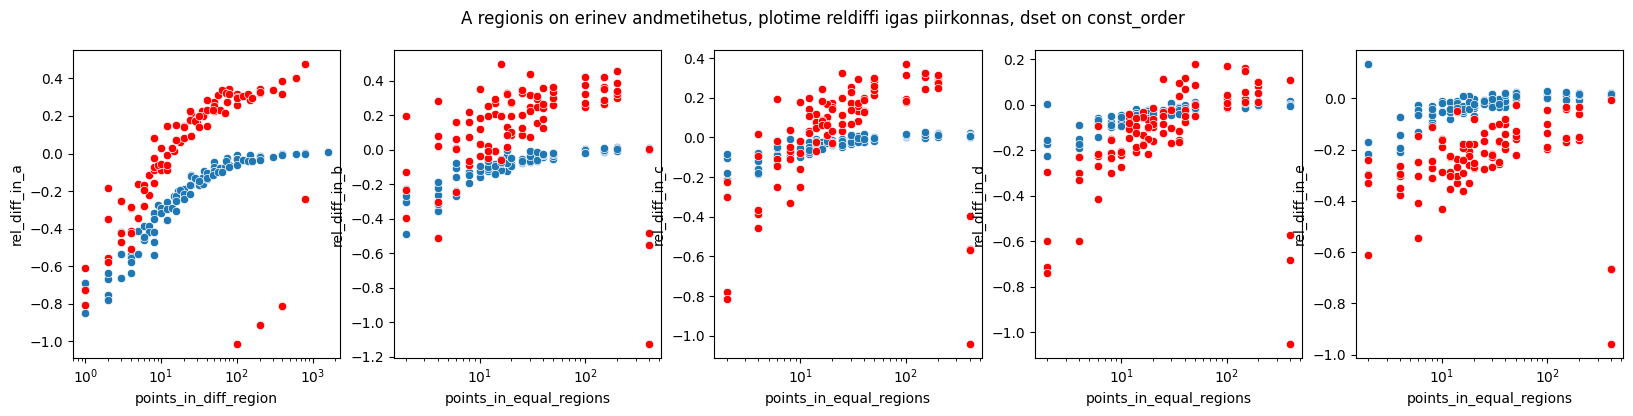

In [ ]:
reg = "A"
dset = paths[0]
dfike = read_data(dset)
test_df = dfike[(dfike.region==reg)&(dfike.points_in_diff_region!=0)] #&(dfike.multiplier==2)

reg_a_pred = transform_and_predict(test_df, "a", True, True, False)
reg_b_pred = transform_and_predict(test_df, "b", True, True, False)
reg_c_pred = transform_and_predict(test_df, "c", True, True, False)
reg_d_pred = transform_and_predict(test_df, "d", True, True, False)
reg_e_pred = transform_and_predict(test_df, "e", True, True, False)

fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
# [a.set_ylim(-1, 1) for a in ax]
# plt.legend(loc='lower right')
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a", ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_equal_regions",y="rel_diff_in_b", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_equal_regions",y="rel_diff_in_c", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_equal_regions",y="rel_diff_in_d", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_equal_regions",y="rel_diff_in_e", ax=ax[4])

sns.scatterplot(x=test_df.points_in_diff_region, y=reg_a_pred, color="red", ax=ax[0])
sns.scatterplot(x=test_df.points_in_equal_regions, y=reg_b_pred, color="red", ax=ax[1])
sns.scatterplot(x=test_df.points_in_equal_regions, y=reg_c_pred, color="red", ax=ax[2])
sns.scatterplot(x=test_df.points_in_equal_regions, y=reg_d_pred, color="red", ax=ax[3])
sns.scatterplot(x=test_df.points_in_equal_regions, y=reg_e_pred, color="red", ax=ax[4])

plt.suptitle(f"{reg} regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas, dset on {dset.split('/')[-1].replace('.csv', '')}")
plt.show()

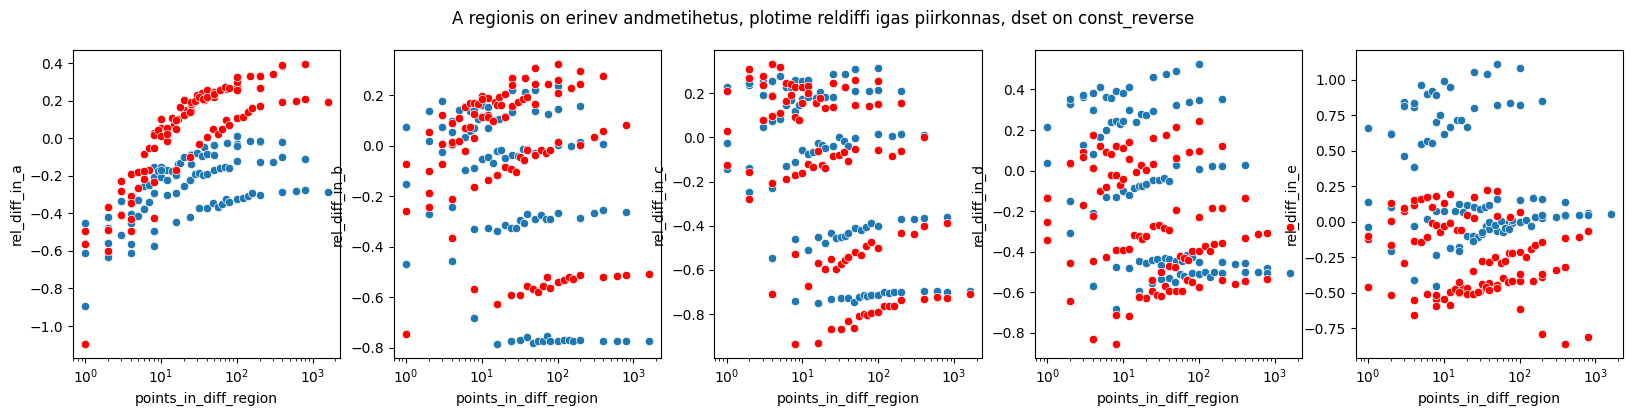

In [ ]:
reg = "A"
dset = paths[1]
dfike = read_data(dset)
test_df = dfike[(dfike.region==reg)&(dfike.points_in_diff_region!=0)] #&(dfike.multiplier==2)

reg_a_pred = transform_and_predict(test_df, "a", True, True, False)
reg_b_pred = transform_and_predict(test_df, "b", True, True, False)
reg_c_pred = transform_and_predict(test_df, "c", True, True, False)
reg_d_pred = transform_and_predict(test_df, "d", True, True, False)
reg_e_pred = transform_and_predict(test_df, "e", True, True, False)

fig, ax = plt.subplots(1,5, figsize=(20, 4))

[a.set_xscale( "log") for a in ax]
# [a.set_ylim(-1, 1) for a in ax]
# plt.legend(loc='lower right')
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_a", ax=ax[0])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_b", ax=ax[1])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_c", ax=ax[2])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_d", ax=ax[3])
sns.scatterplot(data = test_df, x="points_in_diff_region",y="rel_diff_in_e", ax=ax[4])


sns.scatterplot(x=test_df.points_in_diff_region.values, y=reg_a_pred.values, color="red", ax=ax[0])
sns.scatterplot(x=test_df.points_in_diff_region, y=reg_b_pred.values, color="red", ax=ax[1])
sns.scatterplot(x=test_df.points_in_diff_region.values, y=reg_c_pred, color="red", ax=ax[2])
sns.scatterplot(x=test_df.points_in_diff_region.values, y=reg_d_pred, color="red", ax=ax[3])
sns.scatterplot(x=test_df.points_in_diff_region, y=reg_e_pred, color="red", ax=ax[4])


plt.suptitle(f"{reg} regionis on erinev andmetihetus, plotime reldiffi igas piirkonnas, dset on {dset.split('/')[-1].replace('.csv', '')}")
plt.show()

# Teeme puudu oleva tagurpidise transformatsiooni ka tagasi

In [ ]:
reg = "A"
dset = paths[2]
dfike = read_data(dset)
katse_nimi = "200_B_2.0"
print(f"dset on {dset.split('/')[-1].replace('.csv', '')}, katse on {katse_nimi}")
test_df = dfike[dfike.combo_name == katse_nimi]

reg_a_pred = transform_and_predict(test_df, "a", True, True, False).values
reg_b_pred = transform_and_predict(test_df, "b", True, True, False).values
reg_c_pred = transform_and_predict(test_df, "c", True, True, False).values
reg_d_pred = transform_and_predict(test_df, "d", True, True, False).values
reg_e_pred = transform_and_predict(test_df, "e", True, True, False).values

var_a = dfike[dfike.combo_name == katse_nimi].raw_mean2_in_a.values / (reg_a_pred + 1)
var_b = dfike[dfike.combo_name == katse_nimi].raw_mean2_in_b.values / (reg_b_pred + 1)
var_c = dfike[dfike.combo_name == katse_nimi].raw_mean2_in_c.values / (reg_c_pred + 1)
var_d = dfike[dfike.combo_name == katse_nimi].raw_mean2_in_d.values / (reg_d_pred + 1)
var_e = dfike[dfike.combo_name == katse_nimi].raw_mean2_in_e.values / (reg_e_pred + 1)

dset on sin_order, katse on 200_B_2.0


In [ ]:
reg = "A"
dset = paths[1]
dfike = read_data(dset)
katse_nimi = "200_B_0.25"
print(f"dset on {dset.split('/')[-1].replace('.csv', '')}, katse on {katse_nimi}")
test_df = dfike[dfike.combo_name == katse_nimi]
display(test_df.head())

reg_a_pred = transform_and_predict(test_df, "a", True, True, False)
reg_b_pred = transform_and_predict(test_df, "b", True, True, False)
reg_c_pred = transform_and_predict(test_df, "c", True, True, False)
reg_d_pred = transform_and_predict(test_df, "d", True, True, False)
reg_e_pred = transform_and_predict(test_df, "e", True, True, False)

print(reg_a_pred, reg_b_pred, reg_c_pred, reg_d_pred, reg_e_pred, sep="\n")

dset on const_reverse, katse on 200_B_0.25


,region,multiplier,train_size,random_seed,bpoints_in_a,bpoints_in_b,bpoints_in_c,bpoints_in_d,bpoints_in_e,ext_bpoints_in_a,ext_bpoints_in_b,ext_bpoints_in_c,ext_bpoints_in_d,ext_bpoints_in_e,abs_diff_in_a,abs_diff_in_b,abs_diff_in_c,abs_diff_in_d,abs_diff_in_e,rel_diff_in_a,rel_diff_in_b,rel_diff_in_c,rel_diff_in_d,rel_diff_in_e,raw_mean2_in_a,raw_mean2_in_b,raw_mean2_in_c,raw_mean2_in_d,raw_mean2_in_e,raw_mean3_in_a,raw_mean3_in_b,raw_mean3_in_c,raw_mean3_in_d,raw_mean3_in_e,mse_treeningul,mse_grid_testil,mse_treening_andmete_teine_myra,points_in_equal_regions,points_in_diff_region,total_points,combo_name
108,B,0.25,200,24.72093,4.534884,2.0,2.418605,2.930233,3.837209,8.767442,4.697674,4.325581,7.348837,6.372093,-0.196988,0.065943,0.363912,0.345291,0.095565,-0.071074,0.03258,0.23588,0.363708,0.21519,2.549067,2.188485,1.914944,1.299017,0.541324,2.746055,2.122542,1.551033,0.953725,0.44576,3.274634,3.213599,3.578886,40.0,10.0,170.0,200_B_0.25


0   -0.934353
dtype: float64
0   -0.934353
dtype: float64
0   -0.934353
dtype: float64
0   -0.934353
dtype: float64
0   -0.934353
dtype: float64


## Treenime võrgu sellisena 

In [ ]:
def train_model(
    trainX: np.ndarray,
    nn_size: tuple[int, int] = (20, 20),
    optimizer: keras.optimizers = keras.optimizers.Adam(
        learning_rate=0.003, amsgrad=True, epsilon=1e-3),
    epochs: int = 1000,
    batch_size: int = None,
    fn=lambda x: 0*x,
    noise_fn=lambda x: 0.3 *
        np.random.randn(len(x)) + 0.3 * x * np.random.randn(len(x)),
    reverse_fn: bool = False,
    reverse_noise: bool = False,
    seed: int = None
) -> tuple[keras.Model, keras.callbacks.History, tuple[np.ndarray, np.ndarray]]:
    """Mudeli treenimine, voib kasutada erinevaid funktsioone ja mÃ¼ra, tagastab mudeli, ajaloo ja treeningandmed

    :param trainX: treeningX andmed
    :param nn_size: vorgu kihtide suurused, hetkel ainult 2 kihti lubatud, defaults to (20, 20)
    :param optimizer: optimiseerija, hetkel valitud hea vÃ¤iksematele andmehulkadele, defaults to keras.optimizers.Adam( learning_rate=0.003, amsgrad=True, epsilon=1e-3)
    :param epochs: epochide kogus, defaults to 1000
    :param batch_size: batch size, kasutab valemit min(16, kahe aste mis > len(X)/5), defaults to 16
    :param fn: funktsioon mida oppida, defaults to lambdax:0*x
    :param noise_fn: mÃ¼rafn, defaults to lambdax:0.3*np.random.randn(len(x))+0.3*x*np.random.randn(len(x))
    :param reverse_fn: kas pÃ¶Ã¶rata fn tagurpidi, defaults to False
    :param reverse_noise: kas pÃ¶Ã¶rata mÃ¼ra tagurpidi, defaults to False
    :param seed: seed, defaults to 42
    :return: treenitud mudel, ajalugu, treeningandmed
    """
    if seed:
        utils.reset_seeds(seed)

    model = keras.Sequential([
        layers.Input(shape=(1,)),
        layers.Dense(units=nn_size[0], activation='relu', name="layer_1"),
        layers.Dense(units=nn_size[1], activation='relu', name="layer_2"),
        layers.Dense(units=2, activation='linear', name="layer_3")
    ])

    X = trainX

    # koik voimalikud kombod reverse_fn ja reverse_noise. Default on tavalist pidi
    if reverse_fn and reverse_noise:
        y = fn(X[::-1]) + noise_fn(X[::-1])
    elif reverse_fn:
        y = fn(X[::-1]) + noise_fn(X)
    elif reverse_noise:
        y = fn(X) + noise_fn(X[::-1])
    else:
        y = fn(X) + noise_fn(X)

    X_train, y_train = X, y

    model.compile(
        optimizer=optimizer,
        loss=utils.neg_log_likelihood,
    )

    if batch_size is None:
        batch_size = min(16, max(2, 2**int(np.log2(len(trainX)/5+0.001)+1)))

    # TODO: validation_batch_size ja validation_freq saab kasutada et vaadata kuidas viga treeningu jooksul muutub
    h = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0,
                  callbacks=[CustomLogger(100)], shuffle=True, )
    return model, h, (X_train, y_train)


def fn(X):
    return X*np.sin(X)


def noise_fn(X):
    return 0.3 * np.random.randn(len(X)) + 0.3 * X * np.random.randn(len(X))

def create_x_train(train_size, different_place, different_multiplier=1, x_range=(0, 10), n_places=5, seed=None):
    # utils.reset_seeds(seed)

    keskmine_num = train_size/n_places  # A
    erinev_num = different_multiplier*keskmine_num  # B
    piirkond = (x_range[1]-x_range[0])/n_places
    piirkonnad = [(x_range[0]+i*piirkond, x_range[0]+(i+1)*piirkond)
                  for i in range(n_places)]
    #print(f"piirkond: {piirkond}")
    #print(f"piirkonnad: {piirkonnad}")

    X_train = []
    for idx, p in enumerate(piirkonnad):
        if idx == different_place:
            X_train.append(np.random.uniform(p[0], p[1], int(erinev_num)))
        else:
            X_train.append(np.random.uniform(p[0], p[1], int(keskmine_num)))

    X_train = np.concatenate(X_train)
    return X_train


X_train = create_x_train(70, different_place=0, different_multiplier=2.0, x_range=(0, 10), n_places=5, seed=0)
X_test = np.linspace(-2, 12, 10000)
model, _h, (X_train, y_train) = train_model(
    X_train, nn_size=(20, 20), epochs=3000,
    # TODO important: kas algvaartustatakse alati sama seediga
    fn=fn, noise_fn=noise_fn, seed=None,
    reverse_noise=False,
)

Epoch:   0 | Loss: 3.05483e+00
Epoch: 100 | Loss: 2.31292e+00
Epoch: 200 | Loss: 2.21817e+00
Epoch: 300 | Loss: 2.14683e+00
Epoch: 400 | Loss: 2.10422e+00
Epoch: 500 | Loss: 2.02530e+00
Epoch: 600 | Loss: 1.91107e+00
Epoch: 700 | Loss: 1.75718e+00
Epoch: 800 | Loss: 1.57513e+00
Epoch: 900 | Loss: 1.53321e+00
Epoch: 1000 | Loss: 1.48149e+00
Epoch: 1100 | Loss: 1.46731e+00
Epoch: 1200 | Loss: 1.46145e+00
Epoch: 1300 | Loss: 1.47168e+00
Epoch: 1400 | Loss: 1.44606e+00
Epoch: 1500 | Loss: 1.47866e+00
Epoch: 1600 | Loss: 1.41316e+00
Epoch: 1700 | Loss: 1.38693e+00
Epoch: 1800 | Loss: 1.40712e+00
Epoch: 1900 | Loss: 1.39543e+00
Epoch: 2000 | Loss: 1.32348e+00
Epoch: 2100 | Loss: 1.29964e+00
Epoch: 2200 | Loss: 1.30010e+00
Epoch: 2300 | Loss: 1.24319e+00
Epoch: 2400 | Loss: 1.19610e+00
Epoch: 2500 | Loss: 1.14300e+00
Epoch: 2600 | Loss: 1.09434e+00
Epoch: 2700 | Loss: 1.10083e+00
Epoch: 2800 | Loss: 1.05236e+00
Epoch: 2900 | Loss: 1.01878e+00


model contains 30 breaks
1/1 [==============================] - 0s 82ms/step


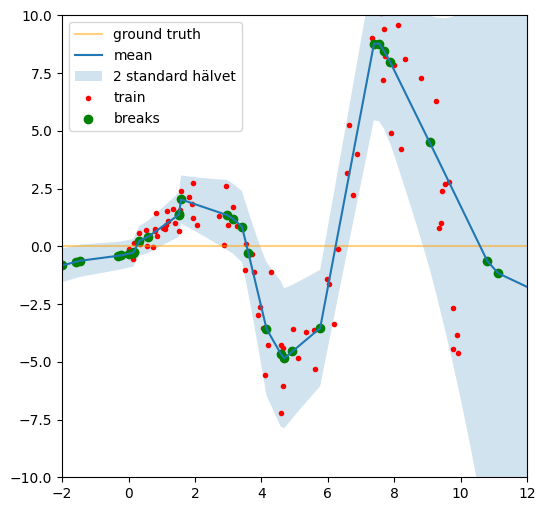

In [ ]:
utils.joonista_variance(model, X_test, X_train, y_train,ground_truth=lambda x:x*0, ylim=(-10,10), xlim=(-2,12))

model contains 30 breaks
1/1 [==============================] - 0s 40ms/step


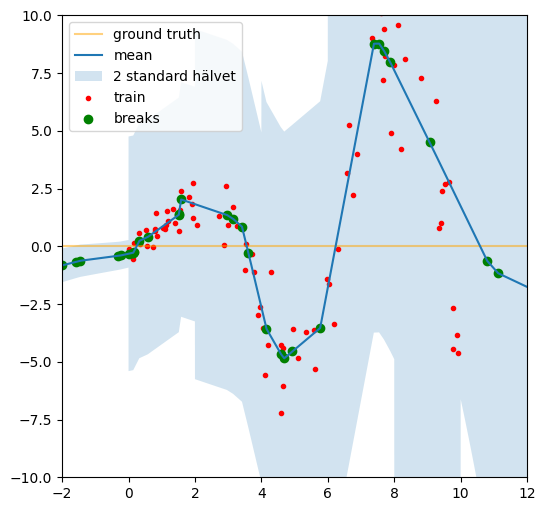

In [ ]:
def joonista_variance_corrected(m: tf.keras.Sequential, X_test, X_train, y_train=None, bpoint_fn=Slopes.breakpoint_finder, *, ground_truth=False, xlim=None, ylim=None, return_fig=False, no_variance=False, n_variances=2, title_text="", korrigeeritud_vars=None):

    bpoints = bpoint_fn(m, X_test)

    _patterns = [bp[1] for bp in bpoints]
    bpoints = [bp[0] for bp in bpoints]

    start, end = xlim if xlim else (-1, 1)

    print(f"model contains {len(bpoints)} breaks")

    y_pred = m.predict(X_test, batch_size=32768)

    if no_variance:
        y_pred_mean = y_pred
    else:
        y_pred_mean, y_pred_logvar = y_pred[:, 0], y_pred[:, 1]
        y_pred_var = np.exp(y_pred_logvar)
        
        if korrigeeritud_vars:
            a,b,c,d,e = korrigeeritud_vars
            y_pred_var[(0<=X_test) & (X_test<2)] = a #y_pred_sd[(0<=X_test) & (X_test<2)]
            y_pred_var[(2<=X_test) & (X_test<4)] = b #y_pred_sd[(2<=X_test) & (X_test<4)]
            y_pred_var[(4<=X_test) & (X_test<6)] = c #y_pred_sd[(4<=X_test) & (X_test<6)]
            y_pred_var[(6<=X_test) & (X_test<8)] = d #y_pred_sd[(6<=X_test) & (X_test<8)]
            y_pred_var[(8<=X_test) & (X_test<10)] = e #y_pred_sd[(8<=X_test) & (X_test<10)]
        
        y_pred_sd = np.sqrt(y_pred_var)



    fig, ax = plt.subplots(figsize=(6, 6))
    plt.xlim(xlim)
    plt.ylim(ylim)

    # absoluutselt õige
    if ground_truth:
        plt.plot(np.linspace(start, end, 1000), ground_truth(np.linspace(
            start, end, 1000)), label="ground truth", alpha=0.5, color="orange")

    plt.plot(X_test, y_pred_mean, label="mean")
    if not no_variance:
        plt.fill_between(X_test, y_pred_mean - n_variances*y_pred_sd,
                         y_pred_mean + n_variances*y_pred_sd, alpha=0.2, label=f"{n_variances} standard hälvet")
    plt.scatter(X_train, y_train, marker='.', color="red", label="train")

    temp_bpoints = list(zip(*bpoints))
    bx, by = temp_bpoints[0], temp_bpoints[1]

    plt.scatter(bx, by, marker="o", color="green", label="breaks")
    plt.title(title_text)
    plt.legend()

    if return_fig:
        return fig

    plt.show()

joonista_variance_corrected(model, X_test, X_train, y_train,ground_truth=lambda x:x*0, ylim=(-10,10), xlim=(-2,12), korrigeeritud_vars=[var_a, var_b, var_c, var_d, var_e])

In [ ]:
letter = "A"
dfike = read_data(paths[2])
dfike["my_points"] =  (dfike["train_size"]/5 * dfike["multiplier"] * (dfike["region"] == letter)) + (dfike["train_size"]/5 * (dfike["region"] !=letter))
dfike["my_points"] += 1.0
dfike['my_points_m1']  = dfike["my_points"] ** (-1)
dfike["my_points_log"] = np.log(dfike["my_points"])
dfike["my_points_logm1"] = (np.log(dfike["my_points"])+1.0 ) ** (-1)

coef2 = (-0.170911703 * (dfike.my_points - np.min(dfike.my_points))) / (dfike.my_points * (np.max(dfike.my_points)-np.min(dfike.my_points)))
my_points_regular_kordajaga_ja_scaleeritud = coef2 * dfike.my_points
my_points_regular_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

coef2 = (0.366006906 * (dfike.my_points_m1 - np.min(dfike.my_points_m1))) / (dfike.my_points_m1 * (np.max(dfike.my_points_m1)-np.min(dfike.my_points_m1)))
my_points_m1_kordajaga_ja_scaleeritud = coef2 * dfike.my_points_m1
my_points_m1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

coef2 = (0.303310425 * (dfike.my_points_log - np.min(dfike.my_points_log))) / (dfike.my_points_log * (np.max(dfike.my_points_log)-np.min(dfike.my_points_log)))
my_points_log_kordajaga_ja_scaleeritud = coef2 * dfike.my_points_log
my_points_log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

coef2 = (-0.996713903 * (dfike.my_points_logm1 - np.min(dfike.my_points_logm1))) / (dfike.my_points_logm1 * (np.max(dfike.my_points_logm1)-np.min(dfike.my_points_logm1)))
my_points_logm1_kordajaga_ja_scaleeritud = coef2 * dfike.my_points_logm1
my_points_logm1_kordajaga_ja_scaleeritud.fillna(0, inplace=True)

my_points_kasitsi = my_points_regular_kordajaga_ja_scaleeritud+my_points_m1_kordajaga_ja_scaleeritud+my_points_log_kordajaga_ja_scaleeritud+my_points_logm1_kordajaga_ja_scaleeritud
my_points_kasitsi = my_points_logm1_kordajaga_ja_scaleeritud
dfike["logm1_combo"] = my_points_kasitsi

<AxesSubplot: xlabel='my_points_combo', ylabel='rel_diff_in_a'>

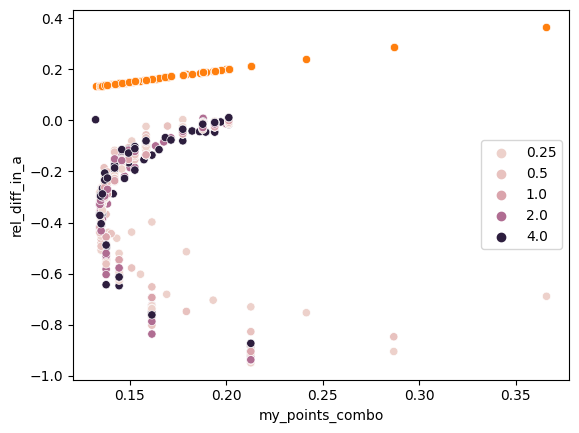

In [ ]:
fig, ax = plt.subplots()
# ax.set_xscale("log")
sns.scatterplot(data = dfike, x="my_points_combo", y="rel_diff_in_"+letter.lower(), hue=multipliers, ax=ax)
sns.scatterplot(data = dfike, x="my_points_combo", y="my_points_combo", ax=ax)

<AxesSubplot: xlabel='my_points_combo', ylabel='rel_diff_in_a'>

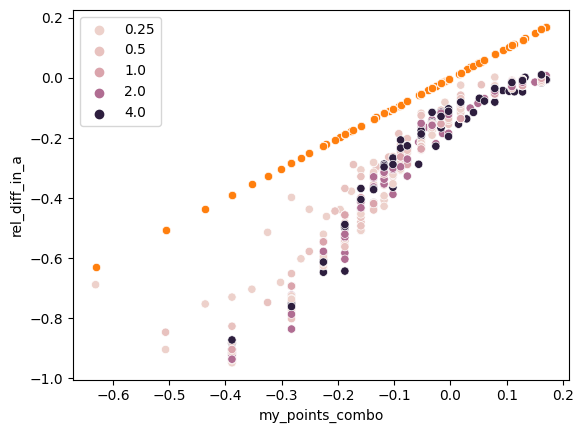

In [ ]:
fig, ax = plt.subplots()
# ax.set_xscale("log")
sns.scatterplot(data = dfike, x="my_points_combo", y="rel_diff_in_"+letter.lower(), hue=multipliers, ax=ax)
sns.scatterplot(data = dfike, x="my_points_combo", y="my_points_combo", ax=ax)

In [ ]:
dfike.columns

Index(['region', 'multiplier', 'train_size', 'random_seed', 'bpoints_in_a',
       'bpoints_in_b', 'bpoints_in_c', 'bpoints_in_d', 'bpoints_in_e',
       'ext_bpoints_in_a', 'ext_bpoints_in_b', 'ext_bpoints_in_c',
       'ext_bpoints_in_d', 'ext_bpoints_in_e', 'abs_diff_in_a',
       'abs_diff_in_b', 'abs_diff_in_c', 'abs_diff_in_d', 'abs_diff_in_e',
       'rel_diff_in_a', 'rel_diff_in_b', 'rel_diff_in_c', 'rel_diff_in_d',
       'rel_diff_in_e', 'raw_mean2_in_a', 'raw_mean2_in_b', 'raw_mean2_in_c',
       'raw_mean2_in_d', 'raw_mean2_in_e', 'raw_mean3_in_a', 'raw_mean3_in_b',
       'raw_mean3_in_c', 'raw_mean3_in_d', 'raw_mean3_in_e', 'mse_treeningul',
       'mse_grid_testil', 'mse_treening_andmete_teine_myra',
       'points_in_equal_regions', 'points_in_diff_region', 'total_points',
       'combo_name', 'my_points', 'my_points_m1', 'my_points_log',
       'my_points_logm1', 'my_points_combo'],
      dtype='object')

<AxesSubplot: xlabel='my_points_combo', ylabel='rel_diff_in_a'>

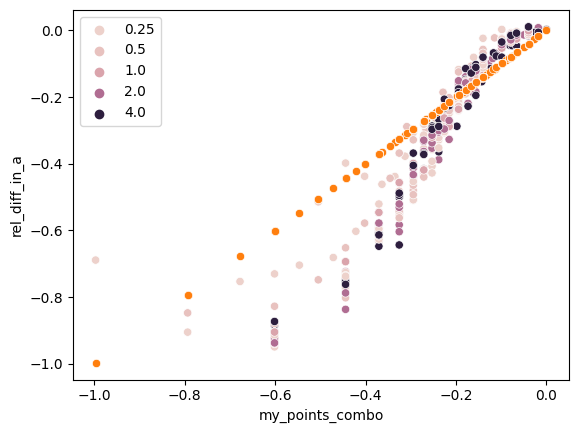

In [ ]:
fig, ax = plt.subplots()
# ax.set_xscale("log")
sns.scatterplot(data = dfike, x="my_points_combo", y="rel_diff_in_"+letter.lower(), hue="multiplier", ax=ax)
sns.scatterplot(data = dfike, x="my_points_combo", y="my_points_combo", ax=ax)

In [ ]:
scaleeritudX.my_points * 0.085575865

0       0.000000
1       0.000053
2       0.000053
3       0.000107
4       0.000107
          ...   
8025    0.010697
8026    0.021394
8027    0.032091
8028    0.042788
8029    0.085576
Name: my_points, Length: 8030, dtype: float64

In [ ]:
coef2 = (0.085575865 * (suurX.my_points - np.min(suurX.my_points))) / (suurX.my_points * (np.max(suurX.my_points)-np.min(suurX.my_points)))

regular_kordajaga_ja_scaleeritud = coef2 * suurX.my_points
regular_kordajaga_ja_scaleeritud

0       0.000000
1       0.000053
2       0.000053
3       0.000107
4       0.000107
          ...   
8025    0.010697
8026    0.021394
8027    0.032091
8028    0.042788
8029    0.085576
Name: my_points, Length: 8030, dtype: float64

In [ ]:
coef2 = (-0.661926834 * (suurX.my_points_m1 - np.min(suurX.my_points_m1))) / (suurX.my_points_m1 * (np.max(suurX.my_points_m1)-np.min(suurX.my_points_m1)))

m1_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_m1
m1_kordajaga_ja_scaleeritud

0      -0.661927
1      -0.330757
2      -0.330757
3      -0.220366
4      -0.220366
          ...   
8025   -0.002882
8026   -0.001238
8027   -0.000688
8028   -0.000413
8029   -0.000000
Name: my_points_m1, Length: 8030, dtype: float64

In [ ]:
coef2 = (0.279312127 * (suurX.my_points_log - np.min(suurX.my_points_log))) / (suurX.my_points_log * (np.max(suurX.my_points_log)-np.min(suurX.my_points_log)))

log_kordajaga_ja_scaleeritud = coef2 * suurX.my_points_log
log_kordajaga_ja_scaleeritud.fillna(0, inplace=True)
log_kordajaga_ja_scaleeritud

0       0.000000
1       0.026239
2       0.026239
3       0.041588
4       0.041588
          ...   
8025    0.200759
8026    0.226904
8027    0.242222
8028    0.253096
8029    0.279312
Name: my_points_log, Length: 8030, dtype: float64

In [ ]:
kasitsi_iludus = regular_kordajaga_ja_scaleeritud+m1_kordajaga_ja_scaleeritud+log_kordajaga_ja_scaleeritud

## Lasso plot

In [ ]:
df, y =transform_no_scaling(read_data(paths[0]), 'b', ['a','c'], ['e'])

In [ ]:
df.head()

,my_bpoints,neighbour_bpoints,distant_bpoints,my_raw_mean2,neighbour_raw_mean2,distant_raw_mean2,my_points,neighbour_points,distant_points,my_points_m1,my_points_log,my_points_logm1,neighbour_points_m1,neighbour_points_log,neighbour_points_logm1,distant_points_m1,distant_points_log,distant_points_logm1,mse_treeningul
0,5.500000,6.125000,0.000000,0.573000,0.755295,2.640577,3.0,2.0,3.0,0.333333,1.098612,0.476505,0.500000,0.693147,0.590616,0.333333,1.098612,0.476505,2.849730
1,5.350000,4.025000,0.150000,0.682587,0.751171,2.288969,5.0,3.0,5.0,0.200000,1.609438,0.383224,0.333333,1.098612,0.476505,0.200000,1.609438,0.383224,2.792928
2,5.827586,4.637931,0.034483,0.749506,0.796207,2.699484,7.0,4.0,7.0,0.142857,1.945910,0.339454,0.250000,1.386294,0.419060,0.142857,1.945910,0.339454,3.449995
3,4.767442,4.941860,0.116279,0.818364,0.862594,2.531897,9.0,6.0,9.0,0.111111,2.197225,0.312771,0.166667,1.791759,0.358197,0.111111,2.197225,0.312771,3.295096
4,3.583333,5.444444,0.111111,0.882617,0.825280,2.668836,11.0,7.0,11.0,0.090909,2.397895,0.294300,0.142857,1.945910,0.339454,0.090909,2.397895,0.294300,3.410475


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming your dataframe is called df, and the target variable is called 'target'
X = df
y = y

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


C:\Users\troosma\AppData\Local\Temp\ipykernel_27940\2069326337.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X, y)
c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo\env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.308e-03, tolerance: 2.690e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mod

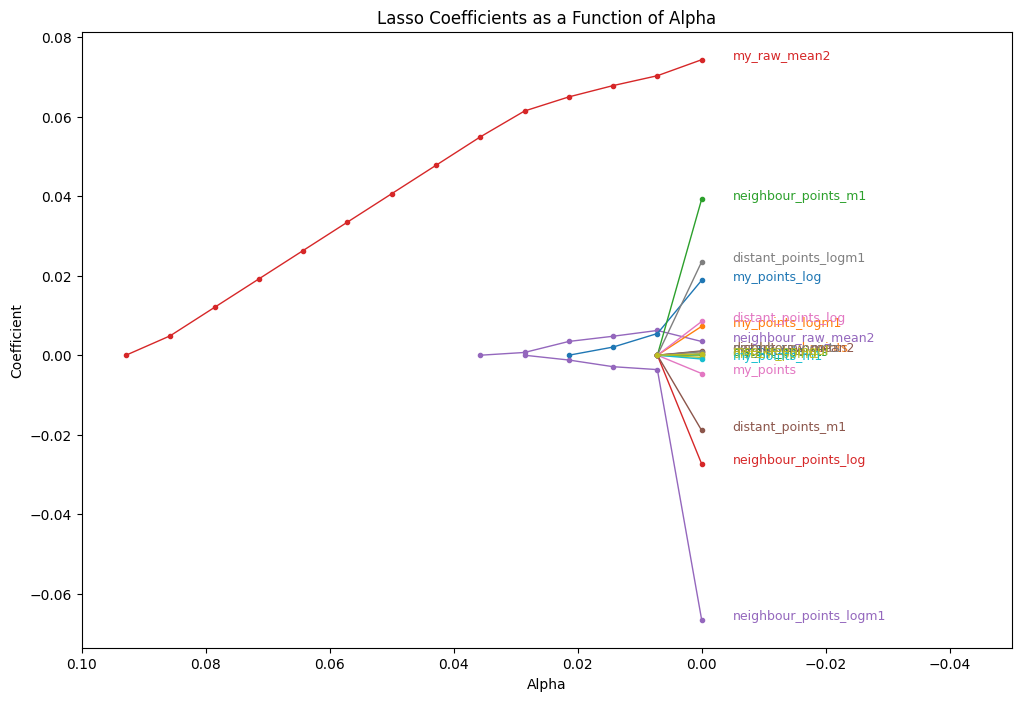

In [ ]:
def lasso_coefficients(alpha_values, X, y):
    coefficients = []

    for alpha in alpha_values:
        lasso = Lasso(alpha=alpha, max_iter=10000)
        lasso.fit(X, y)
        coefficients.append(lasso.coef_)

    return coefficients

def plot_lasso_coefficients(alpha_values, coefficients, feature_names):
    coef_df = pd.DataFrame(coefficients, columns=feature_names)
    coef_df['alpha'] = alpha_values
    coef_df = coef_df.melt(id_vars='alpha', var_name='Feature', value_name='Coefficient')

    plt.figure(figsize=(12, 8))
    palette = sns.color_palette("tab10", len(feature_names))

    for i, feature in enumerate(feature_names):
        feature_coef = coef_df[coef_df['Feature'] == feature]
        zero_coef_idx = feature_coef[feature_coef['Coefficient'] == 0].index
        non_zero_coef = feature_coef.drop(zero_coef_idx[1:], errors='ignore')

        plt.plot(non_zero_coef['alpha'], non_zero_coef['Coefficient'], marker='o', markersize=3, linewidth=1, color=palette[i])
        plt.text(-0.005, feature_coef.iloc[0]['Coefficient'], feature, fontsize=9, color=palette[i], ha='left')

    plt.title('Lasso Coefficients as a Function of Alpha')
    plt.xlabel('Alpha')
    plt.ylabel('Coefficient')
    plt.xlim(-0.05, 0.1)  # Extend the x-axis limit to create more space for labels
    plt.gca().invert_xaxis()  # Reverse the x-axis
    plt.show()

# Generate the Lasso coefficients for a reversed range of alpha values
alpha_values = np.linspace(0.1, 0, 15)[::-1]  # Reverse the alpha_values
coefficients = lasso_coefficients(alpha_values, X_train_scaled, y_train)

plot_lasso_coefficients(alpha_values, coefficients, X.columns)